Previous step before this analysis was `test_cats.ipynb` and getting DeepDISC predictions with `preprocess_eval.sh` and adding magnitudes to those predictions with `add_dd_mags`

# Imports

In [1]:
import json, os, torch, sys
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import seaborn as sns
import FoFCatalogMatching
import pycocotools.mask as mask_util
from multiprocessing import Pool
from functools import partial
# for unrec blend
from astropy.coordinates import search_around_sky, SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table
import pycocotools.mask as mask_util
# detectron2 and deepdisc
from detectron2.config import LazyConfig
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import Instances, Boxes
from deepdisc.astrodet.visualizer import Visualizer, ColorMode
from deepdisc.data_format.register_data import register_data_set
from custom.mappers import FileNameWCSMapper

In [2]:
root_dir = os.path.expanduser('~/lsst_data/')
root_run_dir = os.path.expanduser('~/lsst_runs/')
folder = 'annotations_lvl5'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_cats_dir = f'{root_dir}test_cats_lvl5/test_8k/'
test_data = pd.read_json(test_data_fn)
run_name = 'lsst5_30k_4h200_bs192_ep50'
run_dir = f'{root_run_dir}{run_name}/'
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")
print(f"Run name: {run_name} and run dir: {run_dir}")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 images.
Run name: lsst5_30k_4h200_bs192_ep50 and run dir: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/


In [3]:
cfg_file = os.path.expanduser("~/deepdisc/configs/solo/swin_lsst_job.py")
cfg = LazyConfig.load(cfg_file) # using a Swin Transformer
for key in cfg.get("MISC", dict()).keys():
    cfg[key] = cfg.MISC[key]

cfg.DATASETS.TEST = "test"
cfg.dataloader.augs = None # no augs for test set since we want preds on OG images
cfg.dataloader.test.mapper = FileNameWCSMapper # setting test DataLoader's mapper so that filename gets added to each sample
print(f"Config loaded successfully!")
print(f"Registering training dataset from: {test_data_fn}")
try:
    DatasetCatalog.remove(cfg.DATASETS.TEST)
    MetadataCatalog.remove(cfg.DATASETS.TEST)
except:
    pass
custom_colors = [
    (0, 255, 0),    # green for galaxies
    (0, 0, 255),    # blue for stars
]
astrotest_metadata = register_data_set(
    cfg.DATASETS.TEST, test_data_fn, thing_classes=cfg.metadata.classes, thing_colors=custom_colors
)
test_score_thresh = 0.25
nms_thresh = 0.5
print(f"Dataset registered successfully!")
print(f"Test Score Threshold: {test_score_thresh}")
print(f"NMS Threshold: {nms_thresh}")

Config loaded successfully!
Registering training dataset from: /u/yse2/lsst_data/annotations_lvl5/test_8k.json
Dataset registered successfully!
Test Score Threshold: 0.25
NMS Threshold: 0.5


# Loading in Catalogs

## Selecting Mag Limit Truth Catalog

In [4]:
buffers = [1, 2]
mag_limits = {
    'power_law': 26.07,
    'gold': 25.3,
    'nominal': 26.42,
}

In [5]:
truth_mag_limit = mag_limits['gold'] + buffers[0]
truth_fn = f'{test_cats_dir}test_truth_cat_maglim_{truth_mag_limit:.2f}.parquet'
# truth_fn = f'/u/yse2/lsst_runs/{run_name}/test_cats/full_test_truth_cat.parquet'
print(f'Loading LSST truth catalog from: {truth_fn}')
lsst_truth_cat = pd.read_parquet(truth_fn)

Loading LSST truth catalog from: /u/yse2/lsst_data/test_cats_lvl5/test_8k/test_truth_cat_maglim_26.30.parquet


In [6]:
lsst_truth_cat

,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,bbox,bbox_mode,segmentation
0,9501803150,26.748997,"6,2",67.592682,3258,26.001965,-41.218364,26.015398,3.1,53.666375,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[47.5, 85.5, 11.0, 11.0]",1.0,"[[53, 90, 52, 91, 52, 92, 53, 93, 54, 93, 55, ..."
1,9502520267,24.309986,"6,2",535.905212,3258,23.289883,-41.216024,23.082096,3.1,53.666449,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[40.5, 121.5, 23.0, 23.0]",1.0,"[[52, 126, 51, 127, 49, 127, 46, 130, 46, 131,..."
2,9502520268,24.867851,"6,2",267.290283,3258,23.681042,-41.215661,23.453487,3.1,53.666394,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[42.5, 129.5, 21.0, 21.0]",1.0,"[[51, 134, 48, 137, 48, 139, 47, 140, 48, 141,..."
3,9502520269,26.911549,"6,2",20.394062,3258,25.187178,-41.217791,24.835253,3.1,53.667139,...,NaN,NaN,NaN,None,None,None,None,None,NaN,None
4,9502137039,26.293566,"6,2",116.767540,3258,25.774319,-41.222707,25.825842,3.1,53.668981,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[9.5, 5.5, 15.0, 15.0]",1.0,"[[16, 10, 14, 12, 14, 15, 16, 17, 19, 17, 21, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224187,8637562613,23.666265,"3,4",1118.236816,3442,23.549175,-39.280578,23.394588,3.1,51.385970,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[123.5, 10.5, 25.0, 25.0]",1.0,"[[134, 15, 133, 16, 132, 16, 129, 19, 129, 20,..."
224188,8638094615,25.270082,"3,4",319.394684,3442,25.414097,-39.275942,25.436550,3.1,51.388239,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[94.5, 96.5, 19.0, 19.0]",1.0,"[[102, 101, 99, 104, 99, 109, 102, 112, 107, 1..."
224189,8638642865,25.351679,"3,4",281.525208,3442,25.542938,-39.279342,25.603630,3.1,51.390012,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[70.5, 35.5, 19.0, 19.0]",1.0,"[[79, 40, 78, 41, 77, 41, 76, 42, 76, 43, 75, ..."
224190,8641061146,24.977625,"3,4",410.345825,3442,25.282211,-39.281391,25.341513,3.1,51.388997,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[83.5, -2.5, 21.0, 21.0]",1.0,"[[93, 2, 92, 3, 91, 3, 89, 5, 89, 6, 88, 7, 88..."


In [6]:
def plot_hist(ax, data, bins, color, label, title=None, show_stats=True, alpha=0.8, stat_suffix=''):
    """
    Plot histogram with optional mean and max statistics.
    
    Parameters:
        ax: matplotlib axis
        data: array-like data to plot
        bins: bin edges for histogram
        color: color for histogram
        label: label for histogram
        title: optional title for plot
        show_stats: whether to show mean/max lines
        alpha: transparency value for histogram
        stat_suffix: suffix to add to mean/max labels (e.g., ' (with GT ann)')
    """
    ax.hist(data, bins=bins, color=color, alpha=alpha, label=label)  
    if show_stats and len(data) > 0:
        mean_val = np.nanmean(data)
        max_val = np.nanmax(data)
        ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
                   label=f'Mean{stat_suffix}: {mean_val:.2f}')
        ax.axvline(max_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Max{stat_suffix}: {max_val:.2f}')
    ax.set_xlabel(r'mag $i$')
    ax.set_yscale('log')
    ax.set_ylabel('Number of Objs')
    if title:
        ax.set_title(title)
    ax.legend(frameon=True)

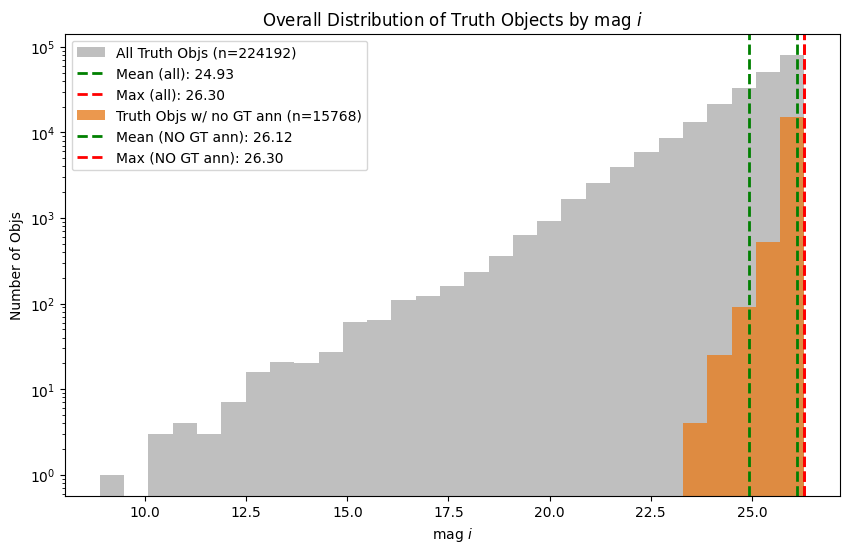

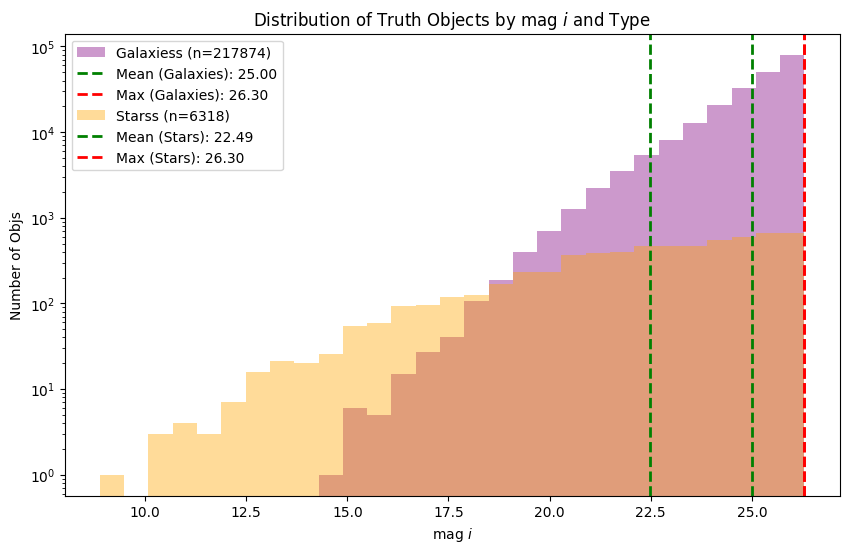

In [25]:
lsst_truth_cat_mags_i = lsst_truth_cat['mag_i'].values
lsst_truth_cat_mags_i_no_ann = lsst_truth_cat[lsst_truth_cat['segmentation'].isna()]['mag_i'].values

bins_full = np.linspace(min(lsst_truth_cat_mags_i), max(lsst_truth_cat_mags_i), 30)
bins_noanns = np.linspace(min(lsst_truth_cat_mags_i_no_ann), max(lsst_truth_cat_mags_i_no_ann), 30)
bins_to_use = bins_full if (bins_full[-1] - bins_full[0]) > (bins_noanns[-1] - bins_noanns[0]) else bins_noanns

cs = {
    'test': '#e67e22',   # orange
    'stars': '#e74c3c',  # red
    'galaxies': '#3498db',  # blue
}
fig, ax = plt.subplots(figsize=(10, 6))
title = r'Overall Distribution of Truth Objects by mag $i$'
# Plot both datasets with different alpha and stat labels
plot_hist(ax, lsst_truth_cat_mags_i, bins=bins_to_use, color='gray', 
          label=f'All Truth Objs (n={len(lsst_truth_cat_mags_i)})', 
          show_stats=True, alpha=0.5, stat_suffix=' (all)')
plot_hist(ax, lsst_truth_cat_mags_i_no_ann, bins=bins_to_use, color=cs['test'], 
          label=f'Truth Objs w/ no GT ann (n={len(lsst_truth_cat_mags_i_no_ann)})', 
          title=title, show_stats=True, alpha=0.8, stat_suffix=' (NO GT ann)')
fig2, ax2 = plt.subplots(figsize=(10, 6))

title = r'Distribution of Truth Objects by mag $i$ and Type'
for cls, label, color in zip([1, 2], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (lsst_truth_cat['truth_type'] == cls) & np.isfinite(lsst_truth_cat['mag_i'])
    mags = lsst_truth_cat.loc[class_mask, 'mag_i'].values
    plot_hist(ax2, mags, bins=bins_to_use, color=color, 
            label=f'{label}s (n={len(mags)})', 
            title=title, show_stats=True, alpha=0.4, stat_suffix=f' ({label})')

In [9]:
print(f"{lsst_truth_cat['segmentation'].isna().sum()/len(lsst_truth_cat) * 100:.2f}% ({lsst_truth_cat['segmentation'].isna().sum()}/{len(lsst_truth_cat)}) of objects in our LSST truth catalog don't have ground truth annotations. \n \
      For more info on what type of objects these are, refer to the test_cats notebook.")
lsst_truth_cat[lsst_truth_cat['segmentation'].isna()]['truth_type'].value_counts()

7.03% (15768/224192) of objects in our LSST truth catalog don't have ground truth annotations. 
       For more info on what type of objects these are, refer to the test_cats notebook.


truth_type
1    15622
2      146
Name: count, dtype: int64

## LSST Detection and DeepDISC Detection Catalogs

In [7]:
pred_fn = f'{run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json'
with open(pred_fn, 'r') as f:
    dd_det = json.load(f)
dd_det_cat = pd.DataFrame(dd_det)

In [8]:
lsst_det_cat = pd.read_json(f'{test_cats_dir}test_det_cat.json')

In [11]:
lsst_det_cat

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,...,psFlux_y,psFlux_i,psFlux_flag_i,psFluxErr_u,psFluxErr_i,psFlux_flag_r,psFlux_z,psFlux_flag_g,psFluxErr_y,psFluxErr_r
0,True,26.054455,0.839360,"6,2",26.391528,1.372450,7.986091,0.0,25.115672,26.035569,...,137.473151,187.999663,False,32.360671,23.595437,False,318.811900,False,141.671744,12.289870
1,True,26.667179,0.836192,"6,2",28.294721,0.410546,5.409555,1.0,26.385419,31.735020,...,78.185926,126.349621,False,31.193805,23.716334,False,57.875292,False,142.150040,12.345701
2,True,23.936885,0.833364,"6,2",26.123854,6.848957,30.585702,1.0,23.963736,26.357919,...,966.598300,722.682427,False,30.990872,23.633574,False,841.039556,False,142.788712,12.284739
3,True,23.860131,0.833865,"6,2",25.951169,8.531146,15.419505,1.0,23.792243,25.744292,...,1037.402854,332.111273,False,31.341562,23.582971,False,604.357679,False,142.209706,12.369967
4,True,NaN,0.836197,"6,2",25.781982,-0.727757,6.410049,1.0,26.214673,26.471734,...,-78.822508,141.965248,False,31.264371,23.755299,False,119.594758,False,143.689217,12.379011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270102,True,26.132345,0.837439,"3,4",26.312939,0.948628,3.461150,1.0,27.125819,26.967916,...,127.956445,84.080833,False,30.017054,23.272279,False,49.115154,False,131.126425,12.173479
270103,True,24.768463,0.839339,"3,4",25.539306,3.527315,11.364457,1.0,25.243289,25.266529,...,449.380905,265.718373,False,31.411536,23.319767,False,291.680293,False,130.997853,12.140590
270104,True,30.346829,0.839340,"3,4",26.752295,NaN,4.967199,1.0,NaN,26.895290,...,2.637961,115.171969,False,30.964624,23.300253,False,1.231965,False,130.771485,12.138144
270105,True,NaN,0.839339,"3,4",26.888039,NaN,3.755131,1.0,25.989924,NaN,...,-1.696022,88.535890,False,30.966545,23.254910,False,122.757510,False,131.025411,12.142344


In [16]:
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.8989448547, 17.9103546143, 65.6764068604, ...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O...",24.178501,24.361794,24.417967,24.268442,24.298439,23.601818
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.8397254944, 122.4864425659, 64.3901672363,...",0.996113,"{'size': [150, 147], 'counts': 'hk64`45L2N101N...",24.193335,24.437212,24.034464,23.551100,23.028345,22.912689
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9977416992, 41.7607955933, 77.0943450928, ...",0.994500,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10...",26.306913,26.051395,25.227131,24.238522,23.961708,23.851330
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.684387207, 133.7821044922, 115.3895263672,...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O...",26.619596,25.951719,25.406775,24.823856,24.747644,25.740545
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0696029663, 100.6747665405, 104.236579895,...",0.988886,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N...",24.696024,24.835098,24.742519,24.630798,24.255783,23.613699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291259,291259,51.387144,-39.274313,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[113.2707748413, 129.224822998, 127.2647018433...",0.630431,"{'size': [144, 147], 'counts': 'Zg`01Z45000MhK...",26.719328,27.458334,27.033850,27.349329,27.236979,25.773390
291260,291260,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.3282623291, 135.4037475586, 146.819656372...",0.527945,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}",NaN,28.596455,27.880468,27.188671,27.090696,26.914551
291261,291261,51.394556,-39.278706,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[11.4410963058, 51.4935569763, 22.4649963379, ...",0.456089,"{'size': [144, 147], 'counts': 'hY23]4000Xna0'}",NaN,28.679873,28.023996,28.183262,28.777231,27.536844
291262,291262,51.386813,-39.279414,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[119.1473388672, 38.5061416626, 130.5223999023...",0.400682,"{'size': [144, 147], 'counts': 'kZa02]42O01Oeh2'}",27.515423,28.312260,27.774233,27.715658,NaN,NaN


(-41.695, -41.715)

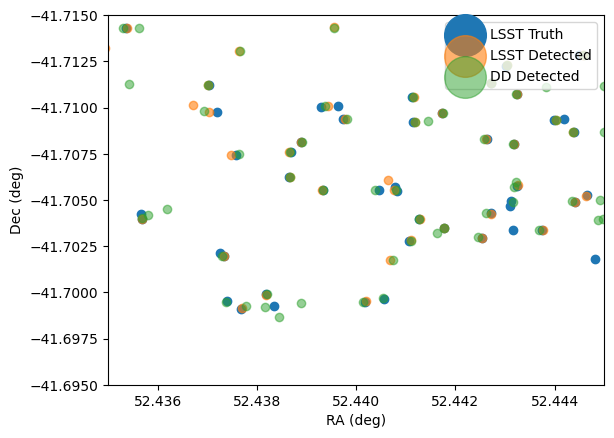

In [13]:
plt.scatter(lsst_truth_cat['ra'], lsst_truth_cat['dec'], label='LSST Truth')
plt.scatter(lsst_det_cat['ra'], lsst_det_cat['dec'], label='LSST Detected', alpha=0.6)
plt.scatter(dd_det_cat['ra'], dd_det_cat['dec'], label='DD Detected', alpha=0.5)
# plt.scatter(lsst_truth_cat['ra'], lsst_truth_cat['dec'], s=1, label='LSST Truth')
# plt.scatter(lsst_det_cat['ra'], lsst_det_cat['dec'], s=1, label='LSST Detected', alpha=0.6)
# plt.scatter(dd_det_cat['ra'], dd_det_cat['dec'], s=1, label='DD Detected', alpha=0.5)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend(markerscale=5, loc='upper right')
# plt.xlim(51.81,51.82)
# plt.ylim(-41.62,-41.64)
plt.xlim(52.435,52.445)
plt.ylim(-41.695,-41.715)

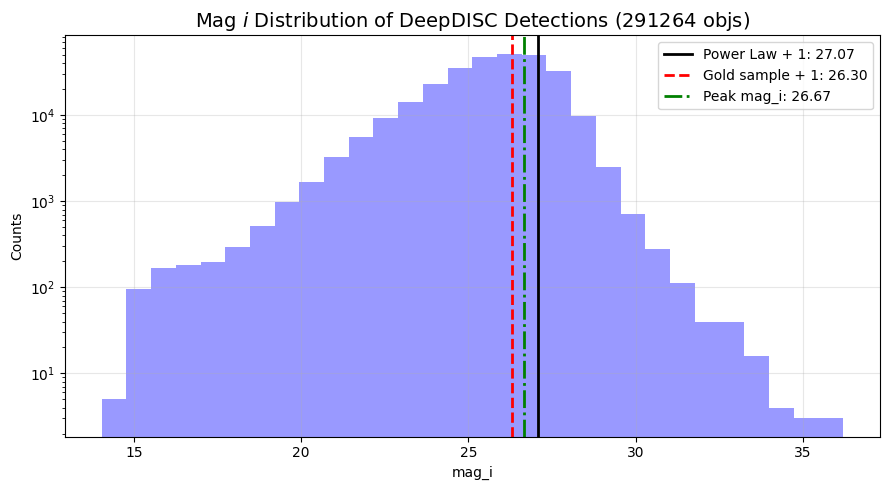

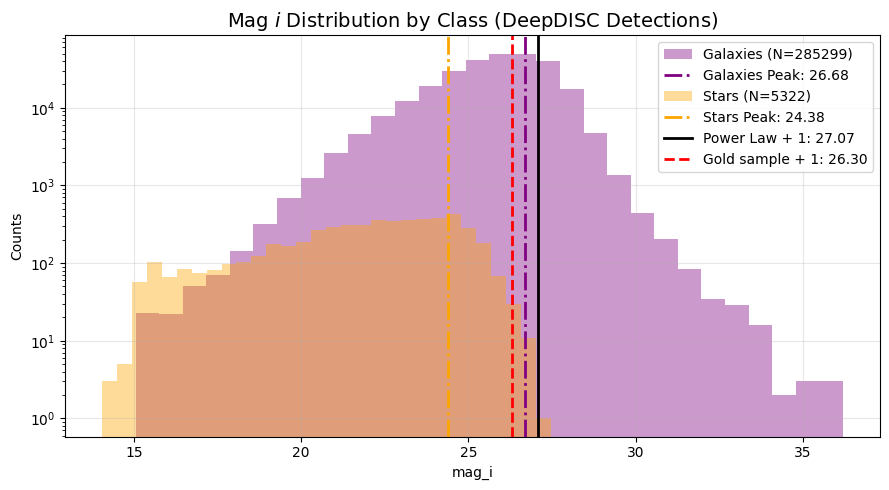

In [19]:
counts, bin_edges = np.histogram(dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(dd_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of DeepDISC Detections ({len(dd_det_cat)} objs)", fontsize=14)
plt.tight_layout()

plt.figure(figsize=(9, 5))
for cls, label, color in zip([0, 1], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (dd_det_cat['class'] == cls) & np.isfinite(dd_det_cat['mag_i'])
    mags = dd_det_cat.loc[class_mask, 'mag_i'].values
    counts, bin_edges = np.histogram(mags, bins=50)
    peak_bin_index = np.argmax(counts)
    peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
    plt.hist(mags, bins=30, alpha=0.4, color=color, label=f"{label} (N={len(mags)})")
    plt.axvline(peak_mag, color=color, linestyle='-.', linewidth=2, label=f'{label} Peak: {peak_mag:.2f}')

plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title("Mag $i$ Distribution by Class (DeepDISC Detections)", fontsize=14)
plt.tight_layout()

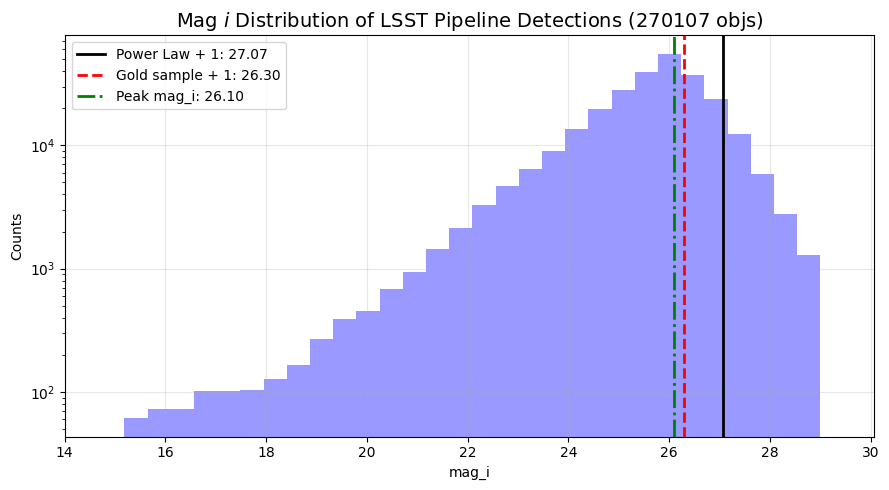

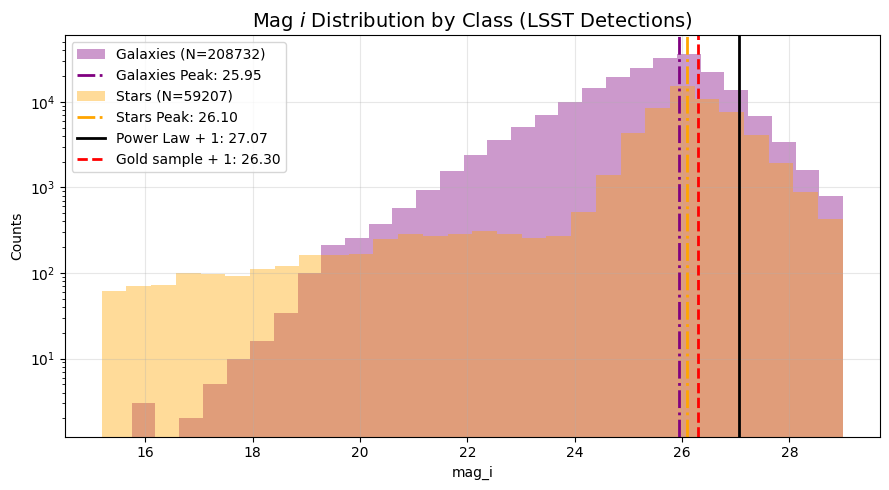

In [21]:
counts, bin_edges = np.histogram(lsst_det_cat[np.isfinite(lsst_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(lsst_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.xlim(14, mag_limits['power_law'] + buffers[0] + 3)
plt.ylabel('Counts')
# plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of LSST Pipeline Detections ({len(lsst_det_cat)} objs)", fontsize=14)
plt.tight_layout()


plt.figure(figsize=(9, 5))
for cls, label, color in zip([1, 0], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (lsst_det_cat['extendedness'] == cls) & np.isfinite(lsst_det_cat['mag_i'])
    mags = lsst_det_cat.loc[class_mask, 'mag_i'].values
    counts, bin_edges = np.histogram(mags, bins=50)
    peak_bin_index = np.argmax(counts)
    peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
    plt.hist(mags, bins=30, alpha=0.4, color=color, label=f"{label} (N={len(mags)})")
    plt.axvline(peak_mag, color=color, linestyle='-.', linewidth=2, label=f'{label} Peak: {peak_mag:.2f}')

plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title("Mag $i$ Distribution by Class (LSST Detections)", fontsize=14)
plt.tight_layout()

## Mag Distribution of All Catalogs

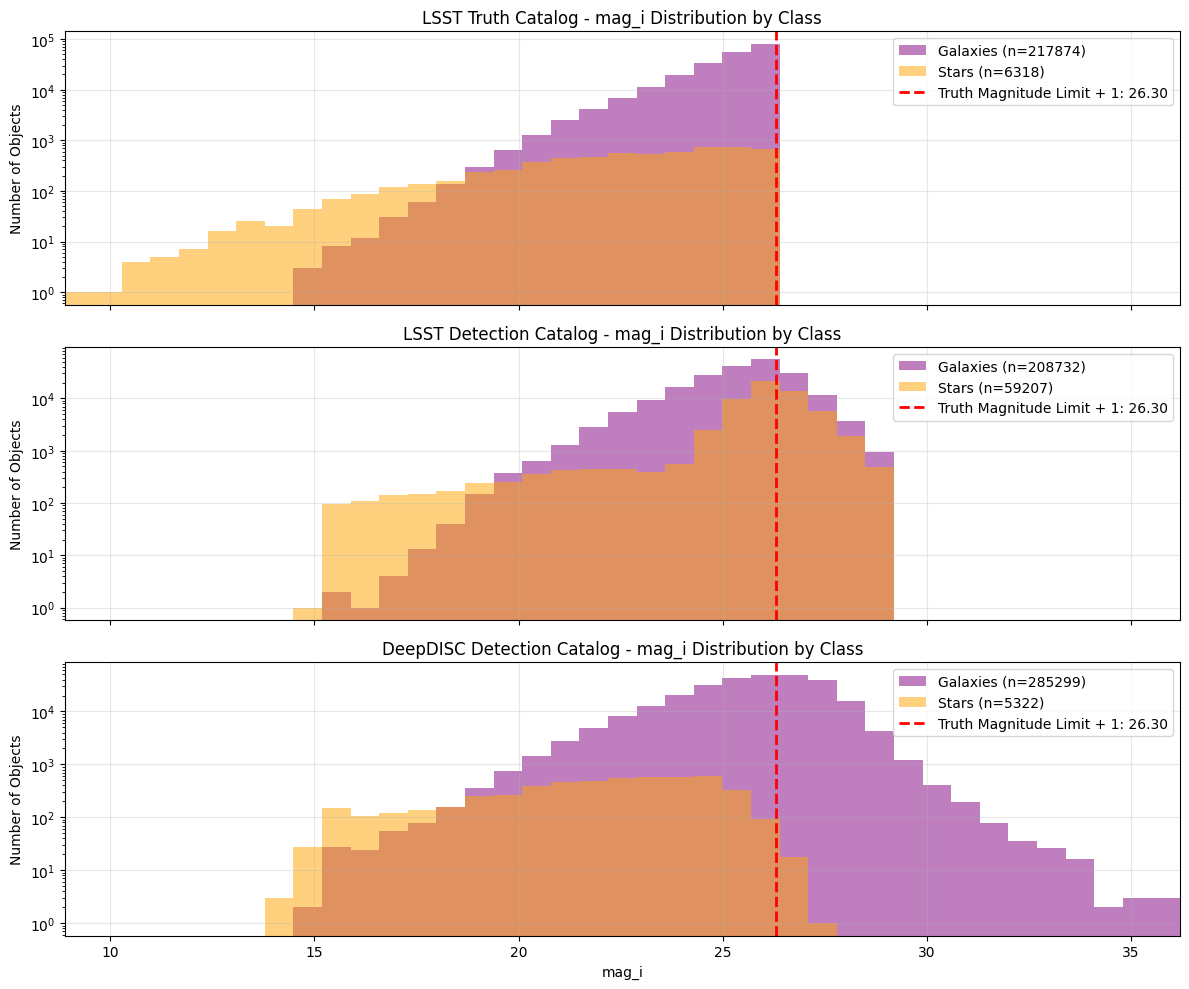

In [31]:
all_mags = np.concatenate([
    lsst_truth_cat[np.isfinite(lsst_truth_cat['mag_i'])]['mag_i'].values,
    lsst_det_cat[np.isfinite(lsst_det_cat['mag_i'])]['mag_i'].values,
    dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values
])
mag_min, mag_max = np.nanmin(all_mags), np.nanmax(all_mags)
common_bins = np.linspace(mag_min, mag_max, 40)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# catalogs: (data, title, class_pairs, class_column)
viz_cats = [
    (lsst_truth_cat, 'LSST Truth Catalog', [(1, 'Galaxies', 'purple'), (2, 'Stars', 'orange')], 'truth_type'),
    (lsst_det_cat, 'LSST Detection Catalog', [(1, 'Galaxies', 'purple'), (0, 'Stars', 'orange')], 'extendedness'),
    (dd_det_cat, 'DeepDISC Detection Catalog', [(0, 'Galaxies', 'purple'), (1, 'Stars', 'orange')], 'class')
]
for idx, (catalog, title, class_pairs, class_column) in enumerate(viz_cats):
    ax = axes[idx]
    for cls, label, color in class_pairs:
        class_mask = (catalog[class_column] == cls) & np.isfinite(catalog['mag_i'])
        mags = catalog.loc[class_mask, 'mag_i'].values
        ax.hist(mags, bins=common_bins, alpha=0.5, color=color, label=f'{label} (n={len(mags)})')
    # Add truth mag limit line
    ax.axvline(truth_mag_limit, color='red', linestyle='--', linewidth=2, 
               label=f'Truth Magnitude Limit + 1: {truth_mag_limit:.2f}')
    ax.set_ylabel('Number of Objects')
    if idx == 2:
        ax.set_xlabel('mag_i')
    ax.set_title(f'{title} - mag_i Distribution by Class', fontsize=12)
    ax.legend(loc='upper right')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

axes[0].set_xlim(mag_min, mag_max)
plt.tight_layout()

# FOF Catalog Matching w/ Detection and Truth Catalogs

The below approach is loosely based on Liang's 2025 et al. (*Catalog-based Detection of Unrecognized Blends in Deep Optical Ground Based Catalogs*) matching criteria in 2.3.

We will use the [FOFCatalogMatching](https://github.com/yymao/FoFCatalogMatching/tree/master) package which uses the friends-of-friends method to iteratively match multiple sky catalogs without the need of specifying the main catalog. As such, we will be matching DeepDISC detections, LSST pipeline detections and the LSST ground truth catalog with linking lengths of 0.5" and 1" and max_friends set to None. It's important that we set max_friends to None because we want to know if one DeepDISC detection corresponds to 2,3 or even 4 truth objects. So, if we set a limit to max_friends, we artifically force the algorithm to ignore complex blends and potentially misclassify them. 
<!-- 
To be considered a "valid" detection (recovered from the truth catalog), the source must meet these two criteria:
- Detection must be within 1" of a truth object
- If multiple truth objects are within 1", the match is assigned to the truth object that is the closest in magnitude (considering all nearest neighbors).

To achieve this, we will use `search_around_sky` which will find all the matches within a given radius. Then, we group all the truth matches for the same detection and sort them based on the detection's observed mag and the truth match's mag. Since it's all sorted now, to keep the best match, we simply drop all the duplicates and keep the first occurrence. -->

In [9]:
cats = {
    'dd_det': dd_det_cat,
    'lsst_det': lsst_det_cat,
    'lsst_truth': lsst_truth_cat,
}

In [10]:
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cats, linking_length=1.0, max_friends=None):
    """
    Find matches between two catalogs using FOF algo.
    
    Parameters:
    -----------
    cat_a, cat_b : pd.DataFrame or astropy.table.Table
        The two catalogs to match. Should have 'ra' and 'dec' columns.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 1.0.
    max_friends : int or None, optional
        Maximum num of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    print(f"Processing {len(cats)} catalogs:", cats.keys())
    # FOF matching needs astropy tables so we convert to tables if they're dfs 
    cat_tables = {}
    for name, cat in cats.items():
        if isinstance(cat, pd.DataFrame):
            cat_tables[name] = Table.from_pandas(cat[['ra', 'dec']])
        else:
            cat_tables[name] = cat
    linking_lengths = {linking_length: max_friends}
    return FoFCatalogMatching.match(
        cat_tables,
        linking_lengths
    )

In [34]:
results1 = find_matches(cats, linking_length=1.0, max_friends=None) # took 40.6s w/ power_law mag, 31.8s w/ gold mag
results1

Processing 3 catalogs: dict_keys(['dd_det', 'lsst_det', 'lsst_truth'])


row_index,catalog_key,group_id
int64,str10,int64
0,dd_det,0
12,lsst_det,0
15,lsst_truth,0
1,dd_det,1
25,lsst_det,1
1,lsst_truth,1
2,dd_det,2
2,lsst_det,2
9,lsst_truth,2


In [35]:
results05 = find_matches(cats, linking_length=0.5, max_friends=None) # took 40.6s w/ power_law mag, 31.8s w/ gold mag
results05

Processing 3 catalogs: dict_keys(['dd_det', 'lsst_det', 'lsst_truth'])


row_index,catalog_key,group_id
int64,str10,int64
0,dd_det,0
12,lsst_det,0
15,lsst_truth,0
1,dd_det,1
25,lsst_det,1
1,lsst_truth,1
2,dd_det,2
2,lsst_det,2
9,lsst_truth,2


Let's understand what each column in the results_1 table means:
- `row_index` is the integer idx of the object in the OG source catalog. For example, `row_index=12` and `catalog_key='lsst_det'` refers to the object located at the 12th row of our original `lsst_det_cat` catalog. We can use this to map object properties to these match results.
- `catalog_key` explains which catalog the object originated from
- `group_id` is a unique identifier for a cluster of objects and all objects sharing the same `group_id` are considered friends AKA "matched". For example, as you can see above, Group 0 contains one DeepDISC detection, one LSST detection, and one LSST truth object. This is a successful, isolated detection for both DeepDISC and the LSST pipeline. There could also be groups where the group only contains an object from the truth catalog which implies a missed detection from both DeepDISC and the LSST pipeline. 

In [36]:
results = {
    "0.5": results05,
    "1.0": results1
}

In [37]:
# loop over results and save each
for ll, res in results.items():
    res.write(f'/u/yse2/lsst_runs/{run_name}/results{ll}_{truth_mag_limit}.ecsv', overwrite=True)

In [38]:
# skip here to re-load saved results (but make sure to set truth_mag_limit correctly)
results = {}
for ll in ['0.5', '1.0']:
    results[ll] = Table.read(f'/u/yse2/lsst_runs/{run_name}/results{ll}_{truth_mag_limit}.ecsv')

In [39]:
results_df = {
    ll: res.to_pandas() for ll, res in results.items()
}

## Creating Obj Info Table

In [40]:
def build_table(results_df, cats, col_config):
    """
    Builds a long-format table by joining requested cols from source cats
    Args:
        results_df: The matched results (row_index, catalog_key, group_id) from FOF matching
        cats: Dict of source cats {'dd': dd_cat, 'lsst': lsst_cat, 'truth': truth_cat}.
        col_config: Dict defining which cols to grab and how to rename them.
                    Format: {'catalog_key': {'orig_col_name': 'new_col_name'}}
    """
    chunks = []
    # iter thru unique cat keys present in results (e.g., 'dd_det', 'lsst_truth')
    for cat_key in results_df['catalog_key'].unique():
        # grabbing subset of results for this specific cat
        subset = results_df[results_df['catalog_key'] == cat_key].copy()
        # Which catalog and config do we use?
        # Map specific cat_keys to our generic cat inputs
        if cat_key == 'dd_det':
            source_cat = cats['dd_det']
            config = col_config.get('dd_det', {})
        elif cat_key == 'lsst_det':
            source_cat = cats['lsst_det']
            config = col_config.get('lsst_det', {})
        elif cat_key == 'lsst_truth':
            source_cat = cats['lsst_truth']
            config = col_config.get('lsst_truth', {})
        else:
            print(f"Didn't recognize catalog key: {cat_key}, skipping...") # in the future, could add more cats (like roman det and roman truth)
            continue
        
        print(f"Processing {len(subset)} entries for catalog key: {cat_key}")
        print(f"Config columns: {config}")
        # select only cols we need from the source cat (listed in our config keys)
        cols_to_fetch = list(config.keys())
        if not cols_to_fetch:
            # If no cols requested for this cat, just keep the IDs
            chunks.append(subset)
            continue
        # now we merge which replaces idxing into the catalog manually
        merged = subset.merge(
            source_cat[cols_to_fetch],
            left_on='row_index',   # idx stored in results
            right_index=True,      # actual idx of source catalog
            how='left'
        )
        # rename cols so they align (e.g. objectId -> id)
        merged.rename(columns=config, inplace=True)
        chunks.append(merged)
    
    # combine everything back together
    final_df = pd.concat(chunks, axis=0).reset_index(drop=True)
    return final_df

In [41]:
cats['dd_det'].columns

Index(['id', 'ra', 'dec', 'class', 'file_name', 'bbox', 'score', 'rle_masks',
       'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'],
      dtype='object')

In [43]:
print(lsst_det_cat.columns)

Index(['clean', 'mag_y', 'psf_fwhm_r', 'patch', 'mag_g', 'snr_y_cModel',
       'snr_i_cModel', 'extendedness', 'mag_z_cModel', 'mag_u',
       ...
       'psFlux_y', 'psFlux_i', 'psFlux_flag_i', 'psFluxErr_u', 'psFluxErr_i',
       'psFlux_flag_r', 'psFlux_z', 'psFlux_flag_g', 'psFluxErr_y',
       'psFluxErr_r'],
      dtype='object', length=139)


In [42]:
print(lsst_truth_cat.columns)

Index(['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y',
       'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z',
       'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id',
       'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift',
       'ellipticity_2_disk_true', 'position_angle_true',
       'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'mag_true_y',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true',
       'size_minor_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
      

In [44]:
# cols we want to pull from each cat {'og_col_name': 'new_col_name'}
config = {
    # copy all cols
    'dd_det': {col: col for col in cats['dd_det'].columns},
    'lsst_det': {
        'objectId': 'id',  # rename to match DD and LSST truth's 'id'
        'parentObjectId': 'parentObjectId',
        'ra': 'ra',
        'dec': 'dec',
        'tract': 'tract',
        'patch': 'patch',
        'Ixx_pixel': 'Ixx_pixel',
        'Iyy_pixel': 'Iyy_pixel',
        'Ixy_pixel': 'Ixy_pixel',
        'I_flag': 'I_flag',
        'IxxPSF_pixel': 'IxxPSF_pixel',
        'IyyPSF_pixel': 'IyyPSF_pixel',
        'IxyPSF_pixel': 'IxyPSF_pixel',
        # ideally separate mags for stars and galaxies (use mag_i_cModel for galaxies but ~300 galaxies have NaN cModel mag_i)
        'mag_u': 'mag_u',
        'mag_g': 'mag_g',
        'mag_r': 'mag_r',
        'mag_i': 'mag_i',
        'mag_z': 'mag_z',
        'mag_y': 'mag_y', 
        'psFlux_u': 'psFlux_u',
        'psFlux_g': 'psFlux_g',
        'psFlux_r': 'psFlux_r',
        'psFlux_i': 'psFlux_i',
        'psFlux_z': 'psFlux_z',
        'psFlux_y': 'psFlux_y',
        'cModelFlux_u': 'cModelFlux_u',
        'cModelFlux_g': 'cModelFlux_g',
        'cModelFlux_r': 'cModelFlux_r',
        'cModelFlux_i': 'cModelFlux_i',
        'cModelFlux_z': 'cModelFlux_z',
        'cModelFlux_y': 'cModelFlux_y',
        'snr_u_cModel': 'snr_u',
        'snr_g_cModel': 'snr_g',
        'snr_r_cModel': 'snr_r',
        'snr_i_cModel': 'snr_i',
        'snr_z_cModel': 'snr_z',
        'snr_y_cModel': 'snr_y',
        'psf_fwhm_u': 'psf_fwhm_u',
        'psf_fwhm_g': 'psf_fwhm_g',
        'psf_fwhm_r': 'psf_fwhm_r',
        'psf_fwhm_i': 'psf_fwhm_i',
        'psf_fwhm_z': 'psf_fwhm_z',
        'psf_fwhm_y': 'psf_fwhm_y',
        'extendedness': 'class', # rename to 'class' to match DD (0 is star, 1 is galaxy)
        'blendedness': 'blendedness',
        'x': 'x',
        'y': 'y',
        'cutout_x': 'cutout_x',
        'cutout_y': 'cutout_y',
        'file_name': 'file_name'
    },
    'lsst_truth': {
        'id': 'id',
        'ra': 'ra',
        'dec': 'dec',
        'truth_type': 'class',  # rename to match DD (2 is star, 1 is galaxy)
        'tract': 'tract',
        'patch': 'patch',
        'mag_u': 'mag_u',
        'mag_g': 'mag_g',
        'mag_r': 'mag_r',
        'mag_i': 'mag_i',
        'mag_z': 'mag_z',
        'mag_y': 'mag_y',
        'flux_u': 'flux_u',
        'flux_g': 'flux_g',
        'flux_r': 'flux_r',
        'flux_i': 'flux_i',
        'flux_z': 'flux_z',
        'flux_y': 'flux_y',
        # sizes
        'size_true': 'size',
        'size_disk_true': 'size_disk',
        'size_bulge_true': 'size_bulge',
        'size_minor_true': 'size_minor',
        'size_minor_disk_true': 'size_minor_disk',
        'size_minor_bulge_true': 'size_minor_bulge',
        # ellipticity
        'ellipticity_1_true': 'e1',
        'ellipticity_2_true': 'e2',
        'ellipticity_1_disk_true': 'e1_disk',
        'ellipticity_2_disk_true': 'e2_disk',
        'ellipticity_1_bulge_true': 'e1_bulge',
        'ellipticity_2_bulge_true': 'e2_bulge',
        # orientation & profile
        'position_angle_true': 'pa_true',
        'position_angle_true_dc2': 'pa_true_dc2',
        'bulge_to_total_ratio_u': 'bttr_u',
        'bulge_to_total_ratio_g': 'bttr_g',
        'bulge_to_total_ratio_r': 'bttr_r',
        'bulge_to_total_ratio_i': 'bttr_i',
        'bulge_to_total_ratio_z': 'bttr_z',
        'bulge_to_total_ratio_y': 'bttr_y',
        # dust/extinction
        'av': 'av',
        'A_v': 'A_v',
        'rv': 'rv',
        'R_v': 'R_v',
        # SDSS filter luminosities (stellar)
        'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed': 'SDSS_diskLum_u',
        'SDSS_filters/diskLuminositiesStellar:SDSS_g:observed': 'SDSS_diskLum_g',
        'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed': 'SDSS_diskLum_r',
        'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed': 'SDSS_diskLum_i',
        'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed': 'SDSS_diskLum_z',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_u:observed': 'SDSS_spheroidLum_u',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed': 'SDSS_spheroidLum_g',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:observed': 'SDSS_spheroidLum_r',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed': 'SDSS_spheroidLum_i',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed': 'SDSS_spheroidLum_z',
        # LSST filter luminosities (stellar)
        'LSST_filters/diskLuminositiesStellar:LSST_u:observed': 'LSST_diskLum_u',
        'LSST_filters/diskLuminositiesStellar:LSST_y:observed': 'LSST_diskLum_y',
        'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed': 'LSST_spheroidLum_u',
        'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed': 'LSST_spheroidLum_y',
        'shear_1': 'shear_1',
        'shear_2': 'shear_2',
        'convergence': 'convergence',
        'host_galaxy': 'host_galaxy',
        'cosmodc2_hp': 'cosmodc2_hp',
        'cosmodc2_id': 'cosmodc2_id',
        'redshift': 'z',
        # Cutout info
        'image_id': 'image_id',
        'height': 'height',
        'width': 'width',
        'tile': 'tile',
        'det_cat_path': 'det_cat_path',
        'truth_cat_path': 'truth_cat_path',
        'wcs': 'wcs',
        'bbox': 'bbox',
        'bbox_mode': 'bbox_mode',
        'segmentation': 'segmentation',
        'cutout_x': 'cutout_x',
        'cutout_y': 'cutout_y',
        'file_name': 'file_name'
    }
}

In [47]:
analysis = {
    ll: build_table(res_df, cats, config) for ll, res_df in results_df.items()
}

Processing 291264 entries for catalog key: dd_det
Config columns: {'id': 'id', 'ra': 'ra', 'dec': 'dec', 'class': 'class', 'file_name': 'file_name', 'bbox': 'bbox', 'score': 'score', 'rle_masks': 'rle_masks', 'mag_u': 'mag_u', 'mag_g': 'mag_g', 'mag_r': 'mag_r', 'mag_i': 'mag_i', 'mag_z': 'mag_z', 'mag_y': 'mag_y'}
Processing 270107 entries for catalog key: lsst_det
Config columns: {'objectId': 'id', 'parentObjectId': 'parentObjectId', 'ra': 'ra', 'dec': 'dec', 'tract': 'tract', 'patch': 'patch', 'Ixx_pixel': 'Ixx_pixel', 'Iyy_pixel': 'Iyy_pixel', 'Ixy_pixel': 'Ixy_pixel', 'I_flag': 'I_flag', 'IxxPSF_pixel': 'IxxPSF_pixel', 'IyyPSF_pixel': 'IyyPSF_pixel', 'IxyPSF_pixel': 'IxyPSF_pixel', 'mag_u': 'mag_u', 'mag_g': 'mag_g', 'mag_r': 'mag_r', 'mag_i': 'mag_i', 'mag_z': 'mag_z', 'mag_y': 'mag_y', 'psFlux_u': 'psFlux_u', 'psFlux_g': 'psFlux_g', 'psFlux_r': 'psFlux_r', 'psFlux_i': 'psFlux_i', 'psFlux_z': 'psFlux_z', 'psFlux_y': 'psFlux_y', 'cModelFlux_u': 'cModelFlux_u', 'cModelFlux_g': 'cMo

In [54]:
analysis['1.0']
# or if we want a weird object in row 500
# weird_obj = analysis['1.0'].iloc[500]
# idx = weird_obj['row_index']
# cat_type = weird_obj['catalog_key']
# or just manual lookup 
# if cat_type == 'dd_det':
#     print(dd_det_cat.loc[idx])

,row_index,catalog_key,group_id,id,ra,dec,class,file_name,bbox,score,...,z,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,bbox_mode,segmentation
0,0,dd_det,0,0,53.666271,-41.221835,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.8989448547, 17.9103546143, 65.6764068604, ...",0.999335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,dd_det,1,1,53.666430,-41.216028,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.8397254944, 122.4864425659, 64.3901672363,...",0.996113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,dd_det,2,2,53.665345,-41.220572,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9977416992, 41.7607955933, 77.0943450928, ...",0.994500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,dd_det,3,3,53.662491,-41.215551,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.684387207, 133.7821044922, 115.3895263672,...",0.991342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,dd_det,4,4,53.663421,-41.217250,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0696029663, 100.6747665405, 104.236579895,...",0.988886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785558,224151,lsst_truth,315540,9501252526,53.601911,-41.392483,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,0.737568,NaN,NaN,NaN,None,None,None,None,NaN,None
785559,224153,lsst_truth,315541,9500885879,53.605171,-41.390790,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,0.678987,NaN,NaN,NaN,None,None,None,None,NaN,None
785560,224160,lsst_truth,315542,9503677434,53.606833,-41.397125,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,1.242632,NaN,NaN,NaN,None,None,None,None,NaN,None
785561,224162,lsst_truth,315543,9507863881,53.599440,-41.395396,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,"[135.5, 44.5, 13.0, 15.0]",NaN,...,1.822696,202.0,149.0,148.0,53.60_-41.4,/u/yse2/lsst_data/truth/53.60_-41.4/det_c202_5...,/u/yse2/lsst_data/truth/53.60_-41.4/truth_c202...,WCSAXES = 2 ...,1.0,"[[142, 49, 140, 51, 140, 54, 142, 56, 143, 56,..."


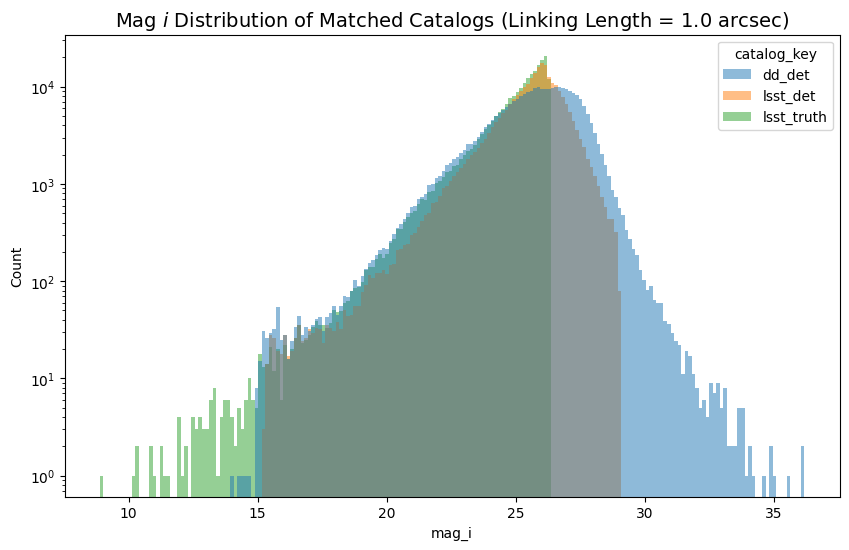

In [49]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=analysis['1.0'], x='mag_i', bins=200, hue='catalog_key', ax=ax, edgecolor=None)
plt.title(f"Mag $i$ Distribution of Matched Catalogs (Linking Length = 1.0 arcsec)", fontsize=14)
ax.set_yscale('log')

In [51]:
analysis['1.0'][analysis['1.0']['catalog_key'] == 'lsst_truth']['mag_i'].describe()

count    224192.000000
mean         24.930192
std           1.396033
min           8.881651
25%          24.406944
50%          25.363270
75%          25.918063
max          26.299999
Name: mag_i, dtype: float64

## Saving Analysis Tables

In [52]:
for ll, analysis_df in analysis.items():
    print(f"Saving analysis table for linking length {ll} with {len(analysis_df)} rows...")
    analysis_df.to_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysis{ll}_{truth_mag_limit}.parquet')

Saving analysis table for linking length 0.5 with 785563 rows...
Saving analysis table for linking length 1.0 with 785563 rows...


In [11]:
# skip here to re-load saved results (but make sure to set truth_mag_limit correctly)
analysis = {}
for ll in ['0.5', '1.0']:
    analysis[ll] = pd.read_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysis{ll}_{truth_mag_limit}.parquet')

# Classifying Groups

Let's now talk about how we're going to classify these different groups. We'll have multiple stages of classification since there are many subcases we will have to consider whenever more than one truth or detected object are present in a group. 

## Stage 1 Classification

At this first stage, we only focus on the counts match. We do not know if the positions match. So, we will have *candidate* recovered/partial blends, and *candidate* shreds since the count is correct but we need to confirm the objects' positions.

- `n_truth = 0, n_det > 0`: Spurious detections (No truth object exists - False Positives)
- `n_truth > 0, n_det = 0`: Missed detections (Truth object exists but was not detected - False Negatives)
- `n_truth = 1, n_det = 1`: Isolated Match (Truth object matches exactly one detection) 
- `n_truth > 1, n_det = 1`: Unrecognized Blend (Multiple truth objects detected as one object)
- `n_truth > 1, n_det = n_truth`: Candidate Resolved Blend (Matched count of truth and detected objects 2->2, 3->3)
- `1 < n_det < n_truth`: Candidate Partial Deblend (More truth objects than detected objects)
- `1 <= n_truth < n_det`: Candidate Shred (More detected objects than truth objects)

In [12]:
def get_stage1_counts(analysis_mlim):
    # group by group_id and catalog_key to get counts
    counts = (
        analysis_mlim.groupby(['group_id', 'catalog_key'])
        .size()
        .unstack(fill_value=0)
    )
    # ensure all cols exist (in case a batch has 0 DD detections total)
    for col in ['dd_det', 'lsst_det', 'lsst_truth']:
        if col not in counts.columns:
            counts[col] = 0
    counts.rename(columns={
        'lsst_truth': 'n_truth',
        'lsst_det': 'n_lsst',
        'dd_det': 'n_dd'
    }, inplace=True)
    return counts

def classify_stg1(counts, prefix, det_col_name, truth_col_name='n_truth'):
    """
    Applies Stage 1 Classification rules (Counts only) to the dataframe
    Args:
        df: The counts dataframe (from get_stage1_counts)
        prefix: String prefix for the output label column (e.g., 'dd' or 'lsst')
        det_col_name: The column name for detection counts (e.g., 'n_dd')
        truth_col_name: The column name for truth counts (default 'n_truth')
    Returns:
        df: The dataframe with a new column '{prefix}_label_stg1' containing the Stage 1 class.
    """
    label_col = f"{prefix}_stg1"
    n_t = counts[truth_col_name]
    n_d = counts[det_col_name]

    conditions = [
        (n_t == 0) & (n_d > 0),  # spurious - false positives
        (n_t > 0) & (n_d == 0),  # missed - false negatives
        (n_t == 0) & (n_d == 0), # correctly rejected - true negative
        (n_t == 1) & (n_d == 1),  # isolated_match
        (n_t > 1) & (n_d == 1),  # unrec_blend since not all N-to-1 groups are physically significant blends
        (n_t > 1) & (n_d == n_t),  # candidate_res_blend
        (n_d > 1) & (n_d < n_t),  # candidate_part_deblend
        (n_t >= 1) & (n_d > n_t),  # candidate_shred - covers simple shreds (1->2) and complex shreds (2->3)
    ]
    classes = [
        'spurious_false_pos',      
        'missed_false_neg',        
        'true_neg',                
        'isolated_match',          
        'unrec_blend',   
        'candidate_res_blend',     
        'candidate_par_deblend',   
        'candidate_shred'          
    ]
    # n/a in case we missed a case but this shld be impossible
    counts[label_col] = np.select(conditions, classes, default='n/a')
    return counts

In [13]:
counts = {}
for ll, analysis_df in analysis.items():
    print(f"Linking Length {ll}: {len(analysis_df)} rows ")
    counts[ll] = get_stage1_counts(analysis_df)
counts['1.0']

Linking Length 0.5: 785563 rows 
Linking Length 1.0: 785563 rows 


catalog_key,n_dd,n_lsst,n_truth
group_id,,,
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
315540,0,0,1
315541,0,0,1
315542,0,0,1


In [14]:
## 0.5" Linking Length
for ll, counts_table in counts.items():
    print(f"Linking Length {ll}: {len(counts_table)} groups ")
    # classify DD dets
    counts_table = classify_stg1(
        counts_table, 
        prefix='dd', 
        det_col_name='n_dd', 
        truth_col_name='n_truth'
    )
    # classify LSST dets
    counts_table = classify_stg1(
        counts_table, 
        prefix='lsst', 
        det_col_name='n_lsst', 
        truth_col_name='n_truth'
    )
    counts[ll] = counts_table

Linking Length 0.5: 354977 groups 
Linking Length 1.0: 315545 groups 


In [15]:
counts['1.0']

catalog_key,n_dd,n_lsst,n_truth,dd_stg1,lsst_stg1
group_id,,,,,
0,1,1,1,isolated_match,isolated_match
1,1,1,1,isolated_match,isolated_match
2,1,1,1,isolated_match,isolated_match
3,1,1,1,isolated_match,isolated_match
4,1,1,1,isolated_match,isolated_match
...,...,...,...,...,...
315540,0,0,1,missed_false_neg,missed_false_neg
315541,0,0,1,missed_false_neg,missed_false_neg
315542,0,0,1,missed_false_neg,missed_false_neg


In [59]:
counts['1.0']['dd_stg1'].value_counts()

dd_stg1
isolated_match           170761
spurious_false_pos        80732
true_neg                  26992
missed_false_neg          14616
candidate_shred            8381
unrec_blend                7662
candidate_res_blend        5682
candidate_par_deblend       719
Name: count, dtype: int64

In [60]:
counts['1.0']['lsst_stg1'].value_counts()

lsst_stg1
isolated_match           170657
spurious_false_pos        81258
true_neg                  26466
missed_false_neg          21746
unrec_blend               13198
candidate_res_blend        1001
candidate_shred             944
candidate_par_deblend       275
Name: count, dtype: int64

In [62]:
counts['0.5']['dd_stg1'].value_counts()

dd_stg1
isolated_match           175204
spurious_false_pos       104424
missed_false_neg          34829
true_neg                  32538
unrec_blend                4720
candidate_shred            2505
candidate_res_blend         715
candidate_par_deblend        42
Name: count, dtype: int64

In [63]:
counts['0.5']['lsst_stg1'].value_counts()

lsst_stg1
isolated_match           179869
spurious_false_pos        84289
true_neg                  52673
missed_false_neg          32312
unrec_blend                5764
candidate_shred              58
candidate_res_blend          10
candidate_par_deblend         2
Name: count, dtype: int64

## Stage 2 Classification

Stage 2 takes the candidate groups identified in Stage 1 (candidate_res_blend, candidate_partial, candidate_shred) and performs **greedy positional matching** to verify whether objects are actually matched or not. This allows us to:

1. **Confirm count-based classifications** - e.g., does a 2-truth, 2-detection group really have 2 clean matches (resolved blend)?
2. **Detect failure modes** - identify shredding, unrecognized components, and spurious detections
3. **Generate detailed match statistics** - track exactly which truth objects matched to which detections

Stage 2 operates in **two phases**:

### Phase 1: Group-Level Classification
For each candidate group, we perform greedy matching (nearest-neighbor pairing with distance threshold) and compute:
- **Match count**: How many truth-detection pairs are within the distance threshold?
- **Unmatched truth count**: How many truth objects have no nearby detection?
- **Unmatched detection count**: How many detections have no nearby truth?
- **Unrecognized component flag**: Do any unmatched truth objects lie within a matched detection?
- **Shredding flag**: Was this a candidate_shred group with excess detections?

Based on these statistics, we assign a **final Stage 2 label**:
- `resolved_blend`: All truth objects matched cleanly (n_matches == n_truth, no unmatched)
- `partial_deblend`: Some truth objects matched, some missed (n_matches >= 2, unmatched_truth > 0)
- `unrec_blend`: Only 1 match despite multiple truth objects (n_matches == 1, n_truth > 1)
- `shredded`: All truth matched but extra spurious detections created (unmatched_det > 0, unmatched_truth == 0)
- `missed_spurious`: No successful matches (n_matches == 0)

So we get a DataFrame with one row per candidate group containing these summary stats and labels.

<!--
For all the *candidate* groups, we perform these steps, 

1.  **Calculate All Distances**: For a group, calculate the angular separation (in arcseconds) between *every* possible pair of detection and truth object (Ex. 3 detections and 2 truth objects gives us 6 distances)
2.  **Find the Closest Pair**: Look at the entire list of distances and identify the single smallest separation.
    *   Check if this minimum distance is within our **threshold** (ex. 0.1 arcsecs)
    *   If it is valid, "lock" this pair as a confirmed match
    *   Remove both the detection and the truth object from the pool of available items
3.  **Repeat**: Look at the remaining available objects and find the *next* smallest distance among them
4.  **Stop** when either:
    *   There are no objects left in one of the lists (detections or truth)
    *   The smallest remaining distance exceeds our threshold

Now, our classification rules depend on which Stage 1 category the group came from.

**For Candidate Partial Deblend (1 < n_det < n_truth)**
Since we start with more truths than detections, so you will always have unmatched_truth ≥ (n_truth - n_det).
Stage 2 OutcomeFinal LabelInterpretationlen(matches) ≥ 2Partial DeblendSuccessfully separated at least 2 components, but missed others (as expected from counts). May also have unmatched_det if some dets were too far from any truth (spurious within group).len(matches) == 1Unrecognized BlendOnly 1 detection matched a truth despite multiple truths existing. Failed to deblend.len(matches) == 0Missed + SpuriousNo valid matches (detections are far from truths).Note: unmatched_det > 0 is possible here if some detections are spurious/misplaced, but unmatched_truth > 0 is guaranteed by the count constraint.

**For Candidate Recognized Blend (n_det == n_truth > 1)**
You start with equal counts, so perfect recovery is possible.
Stage 2 OutcomeFinal LabelInterpretationlen(matches) == n_truth AND unmatched == 0Resolved BlendPerfect 1-to-1 recovery. Success!len(matches) ≥ 2 AND (unmatched_truth > 0 OR unmatched_det > 0)Partial DeblendCounts matched but positions didn't. Some objects were too far to match (detection/truth mismatch).len(matches) == 1Unrecognized BlendOnly 1 pair matched despite N objects. Failed recognition.len(matches) == 0Missed + SpuriousComplete positional mismatch.

**For Candidate Shred (n_det > n_truth ≥ 1)**
You start with more detections than truths, so you will always have unmatched_det ≥ (n_det - n_truth).
Stage 2 OutcomeFinal LabelInterpretationunmatched_truth == 0 AND unmatched_det > 0ShreddedFound all truths but created extra spurious/fragment detections.unmatched_truth > 0 AND unmatched_det > 0 AND len(matches) ≥ 2Partial Deblend + ShreddedComplex failure: missed some truths AND created spurious dets. Consider flagging as both or prioritizing "Partial."len(matches) == 1 AND n_truth > 1Unrecognized Blend + SpuriousOnly 1 truth recovered, extras are spurious.len(matches) == 0Missed + SpuriousNo matches; detections are ghosts.

Stage 1 determines which Stage 2 outcomes are even possible.

current Stage 2 will correctly label the group as "Partial Deblend" (3 truth → 2 det, 2 matches, 1 unmatched truth), but it won't tell you why the 3rd truth was missed. There are two very different physical scenarios:

Scenario A: Clean Partial
Truth 1 at (0, 0) → Detection 1 at (0, 0.05") ✓ Matched
Truth 2 at (0, 1.0") → Detection 2 at (0, 1.05") ✓ Matched
Truth 3 at (0, 5.0") → No detection nearby (truly missed, outside detection threshold)
Scenario B: Partial with Unrecognized Component (Your Original Question)
Truth 1 (small galaxy) at (0, 0) → Detection 1 at (0, 0.05") ✓ Matched
Truth 2 (large galaxy) at (0, 1.0") → Detection 2 at (0, 1.05") ✓ Matched
Truth 3 (small galaxy) at (0, 1.2") → Also within 1.2" of Detection 2 (blended into it!)
Both are "Partial Deblend" by your Stage 2 rules, but Scenario B is scientifically worse because Detection 2 is photometrically contaminated (it contains 2 galaxies' flux).

After greedy matching, add this check:
```python
For each unmatched truth, check distance to all matched detections
has_unrecognized_component = {}
for matched_t_idx, matched_d_idx in matches:
    has_unrecognized_component[matched_d_idx] = False
    
for unmatched_t_idx in unmatched_truth:
    for matched_t_idx, matched_d_idx in matches:
        dist = angular_separation(truth[unmatched_t_idx], det[matched_d_idx])
        if dist <= 1.5:  # Slightly looser than matching threshold
            has_unrecognized_component[matched_d_idx] = True
            break
```
Then you can flag: "Partial Deblend (1 unrecognized component)" for Scenario B vs "Partial Deblend (clean)" for Scenario A.
-->

In [16]:
def classify_stg2_label(stg1_label, n_truth, n_matches, 
                        n_unmatch_t, n_unmatch_d, has_unrec_comp):
    """
    Helper function to determine Stage 2 label based on match statistics.
    
    Args:
        stg1_label: Stage 1 classification (candidate_res_blend, candidate_par_deblend, candidate_shred)
        n_truth: Number of truth objects in group
        n_matches: Number of successful matches
        n_unmatch_t: Number of unmatched truth objects
        n_unmatch_d: Number of unmatched detections
        has_unrec_comp: Whether group has unrecognized components
                        NOTE: Currently used only for metadata flagging, not label determination.
                        Groups with/without unrecognized components get the same label
                        (e.g., both are 'partial_deblend'), but the flag is stored separately
                        to enable downstream photometric contamination analysis.
    
    Returns:
        tuple: (stg2_label, is_shredded)
    """
    # NOTE: has_unrec_comp is intentionally not used in classification logic below.
    # It's a diagnostic flag that provides context about WHY a classification occurred,
    # but doesn't change the fundamental label. It's stored separately in the results.
    
    if stg1_label in ['candidate_res_blend', 'candidate_par_deblend']:
        # equal or fewer dets than truth
        if n_matches == n_truth and n_unmatch_t == 0 and n_unmatch_d == 0:
            return 'resolved_blend', False
        elif n_matches >= 2:
            return 'partial_deblend', False
        elif n_matches == 1:
            return 'unrec_blend', False
        else:  # n_matches == 0
            return 'missed_spurious', False
    elif stg1_label == 'candidate_shred':
        # more dets than truth
        if n_unmatch_t == 0 and n_unmatch_d > 0:
            return 'shredded', False
        elif n_unmatch_t > 0 and n_unmatch_d > 0 and n_matches >= 2:
            return 'partial_deblend', True  # is_shredded = True
        elif n_matches == 1 and n_truth > 1:
            return 'unrec_blend_spurious', False
        else:  # n_matches == 0
            return 'missed_spurious', False
    else:
        # shouldn't reach here for candidate groups
        return 'error', False

def classify_stg2_groups(analysis_df, counts, prefix, max_dist, unrec_threshold):
    """
    Perform Stage 2 classification for candidate groups using greedy positional matching.
    
    This function:
    1. Identifies candidate groups (candidate_res_blend, candidate_partial, candidate_shred)
    2. For each candidate group:
       a. Extract truth and detection positions from analysis_df
       b. Perform greedy matching: pair nearest neighbors within max_dist threshold
       c. Count matches, unmatched truth, and unmatched detections
       d. Check for unrecognized components (unmatched truth near matched detections)
       e. Assign final Stage 2 label based on match statistics
    3. Cache match results for later use in object-level record extraction
    
    Args:
        analysis_df: Long-format DataFrame with all objects (one row per object per group)
                     Columns: group_id, catalog_key, ra, dec, row_index, ...
        counts: DataFrame with Stage 1 results (one row per group)
                Columns: group_id, n_truth, n_{prefix}, {prefix}_stg1, ...
        prefix: Either 'dd' or 'lsst' - which detection catalog to evaluate
        max_dist: Maximum angular separation (arcsec) for a valid match
        unrec_threshold: Distance threshold (arcsec) for detecting unrecognized components
    Returns:
        stage2_results: DataFrame with columns:
            - group_id (index)
            - stg2_label: Final classification (resolved_blend, partial_deblend, etc.)
            - n_matches: Number of truth-detection pairs matched
            - n_unmatched_truth: Number of truth objects with no detection
            - n_unmatched_det: Number of detections with no truth
            - has_unrec_comp: Boolean flag for unrecognized components
            - is_shredded: Boolean flag for shredding (candidate_shred groups only)
            
    Notes:
        Stores match details in global cache for use by extract_stage2_match_records()
        
    Example:
        stage2_dd = classify_stage2_groups(analysis1_mlim, counts1, 'dd', max_dist=1.0, unrec_threshold=2.0)
        counts1 = counts1.merge(stage2_dd, left_index=True, right_index=True, how='left')
    """
    # Identify candidate groups that need Stage 2 processing
    stg1_col = f'{prefix}_stg1'
    det_key = f'{prefix}_det'
    # only grab groups that need stage 2 (all the ones w/ candidate labels)
    cand_labels = ['candidate_res_blend', 'candidate_par_deblend', 'candidate_shred']
    # group_id is an index in counts after stage1 classification
    cand_grps = counts[counts[stg1_col].isin(cand_labels)].index.tolist()
    print(f"Processing {len(cand_grps)} candidate groups for {prefix}...")
    
    truth_df = analysis_df[analysis_df['catalog_key'] == 'lsst_truth']
    det_df = analysis_df[analysis_df['catalog_key'] == det_key]
    # group once instead of filtering per iter
    truth_grouped = truth_df.groupby('group_id')
    det_grouped = det_df.groupby('group_id')
    print(f" Truth objects: {len(truth_df)} objects across {len(truth_grouped)} groups")
    print(f" Detection objects: {len(det_df)} objects across {len(det_grouped)} groups\n")
    
    results = []
    match_cache = {}
    progress_interval = max(1, len(cand_grps) // 10) # print every 10%
    
    for idx, group_id in enumerate(cand_grps):
        if (idx % progress_interval == 0 or idx == len(cand_grps) - 1):
            pct = 100 * (idx + 1) / len(cand_grps)
            print(f"  Processing group {group_id}: {idx+1}/{len(cand_grps)} ({pct:.1f}%)")
        
        # truth objs for this group
        try:
            truth_group = truth_grouped.get_group(group_id)
            truth_coords = truth_group[['ra', 'dec']].values
            truth_row_idxs = truth_group['row_index'].values  # og cat indices
        except KeyError:
            print(f"  WARNING: Group {group_id} has no truth objects")
            truth_coords = np.array([]).reshape(0, 2)
            truth_row_idxs = np.array([])
        
        # detection objs for this group
        try:
            det_group = det_grouped.get_group(group_id)
            det_coords = det_group[['ra', 'dec']].values
            det_row_idxs = det_group['row_index'].values  # og cat indices
        except KeyError:
            print(f"  WARNING: Group {group_id} has no detected objects")
            det_coords = np.array([]).reshape(0, 2)
            det_row_idxs = np.array([])
        
        n_truth = len(truth_coords)
        n_det = len(det_coords)
        
        # Skip if no objects (shouldn't happen for candidates, but handle gracefully)
        if n_truth == 0 or n_det == 0:
            # Get Stage 1 label
            stg1_label = counts.loc[group_id, stg1_col]
            
            results.append({
                'group_id': group_id,
                f'{prefix}_stg2': 'error',
                f'{prefix}_n_matches': 0,
                f'{prefix}_n_unmatched_truth': n_truth,
                f'{prefix}_n_unmatched_det': n_det,
                f'{prefix}_has_unrec': False,
                f'{prefix}_is_shredded': False
            })
            match_cache[group_id] = {
                'matches': [],
                'unmatched_truth': truth_row_idxs.tolist(),
                'unmatched_det': det_row_idxs.tolist()
            }
            continue
        
        # SkyCoord objects for truth and detections
        truth_skycoord = SkyCoord(
            ra=truth_coords[:, 0] * u.degree,
            dec=truth_coords[:, 1] * u.degree
        )
        det_skycoord = SkyCoord(
            ra=det_coords[:, 0] * u.degree,
            dec=det_coords[:, 1] * u.degree
        )
        
        # Greedy matching: iteratively find closest pairs
        matches = []  # List of (truth_idx, det_idx, distance_arcsec)
        matched_truth_idxs = set()
        matched_det_idxs = set()
        
        for _ in range(min(n_truth, n_det)):
            best_dist = np.inf
            best_pair = None
            # Find closest unmatched truth-detection pair
            for t_idx in range(n_truth):
                if t_idx in matched_truth_idxs:
                    continue
                # Match this truth to catalog of detections
                idx, d2d, _ = truth_skycoord[t_idx].match_to_catalog_sky(det_skycoord)
                d_idx = int(idx)  # Index of nearest detection (convert since match_to_catalog_sky returns arr even if single match)
                dist_arcsec = d2d.arcsec  # Distance in arcseconds
                # Skip if this detection is already matched
                if d_idx in matched_det_idxs:
                    continue
                # Track the best pair
                if dist_arcsec < best_dist:
                    best_dist = dist_arcsec
                    best_pair = (t_idx, d_idx)
            # If best pair is within threshold, add to matches
            if best_pair and best_dist <= max_dist:
                t_idx, d_idx = best_pair
                matches.append((t_idx, d_idx, best_dist))
                matched_truth_idxs.add(t_idx)
                matched_det_idxs.add(d_idx)
            else:
                # No more valid matches
                break
        # Identify unmatched objects
        unmatched_truth_idxs = [i for i in range(n_truth) if i not in matched_truth_idxs]
        unmatched_det_idxs = [i for i in range(n_det) if i not in matched_det_idxs]
        n_matches = len(matches)
        n_unmatch_t = len(unmatched_truth_idxs)
        n_unmatch_d = len(unmatched_det_idxs)
        
        # Check for unrecognized components
        # (unmatched truth objects near matched detections)
        has_unrec_comp = False
        if n_unmatch_t > 0 and n_matches > 0:
            # Get unmatched truth coordinates
            unmatch_truth_skycoord = truth_skycoord[unmatched_truth_idxs]
            # Get matched detection coordinates
            matched_det_idx_list = [d_idx for _, d_idx, _ in matches]
            matched_det_skycoord = det_skycoord[matched_det_idx_list]
            # For each unmatched truth, check distance to all matched detections
            for unmatch_truth in unmatch_truth_skycoord:
                idx, d2d, _ = unmatch_truth.match_to_catalog_sky(matched_det_skycoord)
                dist_arcsec = d2d.arcsec
                if dist_arcsec <= unrec_threshold:
                    has_unrec_comp = True
                    break
        
        # Get Stage 1 label for classification
        stg1_label = counts.loc[group_id, stg1_col]
        n_truth_count = counts.loc[group_id, 'n_truth']
        
        # Determine final Stage 2 label based on match statistics
        stg2_label, is_shredded = classify_stg2_label(
            stg1_label, n_truth_count, n_matches, 
            n_unmatch_t, n_unmatch_d, has_unrec_comp
        )
        
        # Store results
        results.append({
            'group_id': group_id,
            f'{prefix}_stg2': stg2_label,
            f'{prefix}_n_matches': n_matches,
            f'{prefix}_n_unmatched_truth': n_unmatch_t,
            f'{prefix}_n_unmatched_det': n_unmatch_d,
            f'{prefix}_has_unrec': has_unrec_comp,
            f'{prefix}_is_shredded': is_shredded
        })
        
        # Cache match details for later extraction (store original row indices)
        match_cache[group_id] = {
            'matches': [
                (truth_row_idxs[t_idx], det_row_idxs[d_idx], dist)
                for t_idx, d_idx, dist in matches
            ],
            'unmatched_truth': [truth_row_idxs[i] for i in unmatched_truth_idxs],
            'unmatched_det': [det_row_idxs[i] for i in unmatched_det_idxs]
        }
    
    # Convert results to DataFrame
    if results:
        # 
        stage2_df = pd.DataFrame(results).set_index('group_id')
    else:
        # No candidate groups - return empty DataFrame with correct schema
        stage2_df = pd.DataFrame(columns=[
            'group_id', f'{prefix}_stg2', f'{prefix}_n_matches', 
            f'{prefix}_n_unmatched_truth', f'{prefix}_n_unmatched_det', 
            f'{prefix}_has_unrec', f'{prefix}_is_shredded'
        ]).set_index('group_id')
    
    return stage2_df, match_cache

In [ ]:
counts['1.0']

catalog_key,n_dd,n_lsst,n_truth,dd_stg1,lsst_stg1
group_id,,,,,
0,1,1,1,isolated_match,isolated_match
1,1,1,1,isolated_match,isolated_match
2,1,1,1,isolated_match,isolated_match
3,1,1,1,isolated_match,isolated_match
4,1,1,1,isolated_match,isolated_match
...,...,...,...,...,...
315540,0,0,1,missed_false_neg,missed_false_neg
315541,0,0,1,missed_false_neg,missed_false_neg
315542,0,0,1,missed_false_neg,missed_false_neg


In [ ]:
analysis['1.0']

,row_index,catalog_key,group_id,id,ra,dec,class,file_name,bbox,score,...,z,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,bbox_mode,segmentation
0,0,dd_det,0,0,53.666271,-41.221835,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.8989448547, 17.9103546143, 65.6764068604, ...",0.999335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,dd_det,1,1,53.666430,-41.216028,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.8397254944, 122.4864425659, 64.3901672363,...",0.996113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,dd_det,2,2,53.665345,-41.220572,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9977416992, 41.7607955933, 77.0943450928, ...",0.994500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,dd_det,3,3,53.662491,-41.215551,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.684387207, 133.7821044922, 115.3895263672,...",0.991342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,dd_det,4,4,53.663421,-41.217250,0.0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0696029663, 100.6747665405, 104.236579895,...",0.988886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785558,224151,lsst_truth,315540,9501252526,53.601911,-41.392483,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,0.737568,NaN,NaN,NaN,None,None,None,None,NaN,None
785559,224153,lsst_truth,315541,9500885879,53.605171,-41.390790,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,0.678987,NaN,NaN,NaN,None,None,None,None,NaN,None
785560,224160,lsst_truth,315542,9503677434,53.606833,-41.397125,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,1.242632,NaN,NaN,NaN,None,None,None,None,NaN,None
785561,224162,lsst_truth,315543,9507863881,53.599440,-41.395396,1.0,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,"[135.5, 44.5, 13.0, 15.0]",NaN,...,1.822696,202.0,149.0,148.0,53.60_-41.4,/u/yse2/lsst_data/truth/53.60_-41.4/det_c202_5...,/u/yse2/lsst_data/truth/53.60_-41.4/truth_c202...,WCSAXES = 2 ...,1.0,"[[142, 49, 140, 51, 140, 54, 142, 56, 143, 56,..."


In [17]:
_stage2_match_cache = {}
# Greedy matching classification for candidates
# for 0.5" use 0.25 as max dist and unrec threshold to be 0.5"
# for 1.0" use 0.5 as max dist and unrec threshold to be 1.0"
for ll, analysis_df, counts_df in zip(['0.5', '1.0'], analysis.values(), counts.values()):
    print(f"Processing Stage 2 classification for Linking Length {ll}...")
    if ll == '0.5':
        max_dist = 0.25
        unrec_threshold = 0.5
    else: # ll == '1.0'
        max_dist = 0.5
        unrec_threshold = 1.0
    # DD detections
    print(f"\n--- Processing DD detections ---")
    stage2_dd, match_cache_dd = classify_stg2_groups(
        analysis_df, counts_df, 'dd', 
        max_dist=max_dist, 
        unrec_threshold=unrec_threshold
    )
    # merging on group index since both counts and stage2_dd have group_id as index
    counts_df = counts_df.merge(stage2_dd, left_index=True, right_index=True, how='left')
    # LSST detections
    print(f"\n--- Processing LSST detections ---")
    stage2_lsst, match_cache_lsst = classify_stg2_groups(
        analysis_df, counts_df, 'lsst', 
        max_dist=max_dist, 
        unrec_threshold=unrec_threshold
    )
    # merging on group index since both counts and stage2_dd have group_id as index
    counts_df = counts_df.merge(stage2_lsst, left_index=True, right_index=True, how='left')
    # Store caches globally for later use
    _stage2_match_cache[ll] = {
        'dd': match_cache_dd,
        'lsst': match_cache_lsst
    }
    # Update counts
    counts[ll] = counts_df

Processing Stage 2 classification for Linking Length 0.5...

--- Processing DD detections ---
Processing 3262 candidate groups for dd...
 Truth objects: 224192 objects across 218015 groups
 Detection objects: 291264 objects across 287610 groups

  Processing group 168: 1/3262 (0.0%)
  Processing group 27728: 327/3262 (10.0%)
  Processing group 59324: 653/3262 (20.0%)
  Processing group 95763: 979/3262 (30.0%)
  Processing group 125634: 1305/3262 (40.0%)
  Processing group 157299: 1631/3262 (50.0%)
  Processing group 190176: 1957/3262 (60.0%)
  Processing group 221563: 2283/3262 (70.0%)
  Processing group 249334: 2609/3262 (80.0%)
  Processing group 281811: 2935/3262 (90.0%)
  Processing group 350390: 3261/3262 (100.0%)
  Processing group 352709: 3262/3262 (100.0%)

--- Processing LSST detections ---
Processing 70 candidate groups for lsst...
 Truth objects: 224192 objects across 218015 groups
 Detection objects: 270107 objects across 269992 groups

  Processing group 4579: 1/70 (1.4%)


In [76]:
counts['1.0']['dd_stg2'].value_counts()

dd_stg2
shredded                7426
resolved_blend          3985
unrec_blend             1573
missed_spurious         1010
partial_deblend          650
unrec_blend_spurious     138
Name: count, dtype: int64

In [77]:
counts['1.0']

,n_dd,n_lsst,n_truth,dd_stg1,lsst_stg1,dd_stg2,dd_n_matches,dd_n_unmatched_truth,dd_n_unmatched_det,dd_has_unrec,dd_is_shredded,lsst_stg2,lsst_n_matches,lsst_n_unmatched_truth,lsst_n_unmatched_det,lsst_has_unrec,lsst_is_shredded
group_id,,,,,,,,,,,,,,,,,
0,1,1,1,isolated_match,isolated_match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,isolated_match,isolated_match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1,isolated_match,isolated_match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,1,isolated_match,isolated_match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,1,isolated_match,isolated_match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315540,0,0,1,missed_false_neg,missed_false_neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315541,0,0,1,missed_false_neg,missed_false_neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315542,0,0,1,missed_false_neg,missed_false_neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Infer Stage 1 Match Counts
Stage 1 groups (isolated_match, unrec_blend, spurious, missed) didn't go through greedy matching, so their match count columns are NaN. We need to fill these based on deterministic rules

In [18]:
def infer_stg1_matches(counts, prefix):
    """
    Infer match counts for groups that were classified in Stage 1 only so we
    don't have to fill them with NaN or 0 blindly
    Args:
        counts: DataFrame with Stage 1 and Stage 2 results
        prefix: 'dd' or 'lsst'
    
    Returns:
        counts: DataFrame with imputed match counts
    """
    stg1_col = f'{prefix}_stg1'
    stg2_col = f'{prefix}_stg2'
    n_det_col = f'n_{prefix}'
    match_col = f'{prefix}_n_matches'
    unmatch_t_col = f'{prefix}_n_unmatched_truth'
    unmatch_d_col = f'{prefix}_n_unmatched_det'
    
    # Only infer where Stage 2 wasn't run (stg2 is NaN)
    stage1_only_mask = counts[stg2_col].isna()
    stage1_only = counts[stage1_only_mask].copy()
    # Validation: ensure these are actually Stage 1 labels
    stage1_labels = ['isolated_match', 'unrec_blend', 'spurious_false_pos', 'missed_false_neg', 'true_neg']
    if not stage1_only[stg1_col].isin(stage1_labels).all():
        unexpected = stage1_only[~stage1_only[stg1_col].isin(stage1_labels)][stg1_col].unique()
        print(f"  WARNING: Unexpected labels found in Stage 1 only groups: {unexpected}")
    
    conds = [
        # ISOLATED MATCH (1 truth, 1 det)
        # assumed to be a successful 1-to-1 match
        stage1_only[stg1_col] == 'isolated_match',
        # UNRECOGNIZED BLEND (N truth, 1 det)
        # The single detection matches the nearest truth, rest are missed
        stage1_only[stg1_col] == 'unrec_blend',
        # SPURIOUS / FALSE POSITIVE (0 truth, N det)
        # No truth objects exist, so all detections are unmatched
        stage1_only[stg1_col] == 'spurious_false_pos',
        # MISSED / FALSE NEGATIVE (N truth, 0 det)
        # No detections exist, so all truths are unmatched
        stage1_only[stg1_col] == 'missed_false_neg'
        # true_neg will have default values of 0 since there's nothing to match
    ]
    match_vals = [
        1,  # isolated_match 
        1,  # unrec_blend (1 truth matched to the single det)
        0,  # spurious
        0,  # missed
    ]
    unmatch_t_vals = [
        0,  # isolated_match
        stage1_only['n_truth'] - 1,  # unrec_blend
        0,  # spurious
        stage1_only['n_truth'],  # missed
    ]
    unmatch_d_vals = [
        0,  # isolated_match
        0,  # unrec_blend
        stage1_only[n_det_col],  # spurious
        0,  # missed
    ]

    counts.loc[stage1_only_mask, match_col] = np.select(
        conds, match_vals, default=0
    )
    counts.loc[stage1_only_mask, unmatch_t_col] = np.select(
        conds, unmatch_t_vals, default=0
    )
    counts.loc[stage1_only_mask, unmatch_d_col] = np.select(
        conds, unmatch_d_vals, default=0
    )
    return counts

In [19]:
print("Inferring match counts for Stage 1 groups...\n")
for ll, counts_df in counts.items():
    print(f"Processing Linking Length {ll}\"...")    
    # Infer match counts for DD
    print(f"  Inferring DD match counts...")
    counts_df = infer_stg1_matches(counts_df, 'dd')
    # Infer match counts for LSST
    print(f"  Inferring LSST match counts...")
    counts_df = infer_stg1_matches(counts_df, 'lsst')
    # Update counts dictionary
    counts[ll] = counts_df
    
    print(f"Linking length {ll}\" complete!")
    print(f"    DD groups with matches > 0: {(counts_df['dd_n_matches'] > 0).sum()}")
    print(f"    LSST groups with matches > 0: {(counts_df['lsst_n_matches'] > 0).sum()}\n")

# Verify no NaN remains in match columns
print("Verifying all match counts are filled...")
for ll, counts_df in counts.items():
    assert counts_df['dd_n_matches'].notna().all(), f"{ll}\" DD match counts still have NaN!"
    assert counts_df['lsst_n_matches'].notna().all(), f"{ll}\" LSST match counts still have NaN!"
    assert counts_df['dd_n_unmatched_truth'].notna().all(), f"{ll}\" DD unmatched truth still have NaN!"
    assert counts_df['lsst_n_unmatched_truth'].notna().all(), f"{ll}\" LSST unmatched truth still have NaN!"
    assert counts_df['dd_n_unmatched_det'].notna().all(), f"{ll}\" DD unmatched det still have NaN!"
    assert counts_df['lsst_n_unmatched_det'].notna().all(), f"{ll}\" LSST unmatched det still have NaN!"

print("All match counts inferred successfully!")

Inferring match counts for Stage 1 groups...

Processing Linking Length 0.5"...
  Inferring DD match counts...
  Inferring LSST match counts...
Linking length 0.5" complete!
    DD groups with matches > 0: 182317
    LSST groups with matches > 0: 185676

Processing Linking Length 1.0"...
  Inferring DD match counts...
  Inferring LSST match counts...
Linking length 1.0" complete!
    DD groups with matches > 0: 192195
    LSST groups with matches > 0: 186000

Verifying all match counts are filled...
All match counts inferred successfully!


#### Finalize Group Labels
Combine Stage 1 and Stage 2 labels into final classification labels. Fill in boolean flags (has_unrec, is_shredded) for groups that only went through Stage 1.

In [20]:
def create_final_labels(counts):
    """
    Create final classification labels based on Stage 1 and Stage 2 results
    Args:
        counts: DataFrame with Stage 1 and Stage 2 classification results
    Returns:
        DataFrame with final labels and filled NaN values
    """
    # For non-candidate groups (Stage 2 is NaN), use Stage 1 label
    # For candidate groups, use Stage 2 label
    counts['dd_final'] = counts['dd_stg2'].fillna(counts['dd_stg1'])
    counts['lsst_final'] = counts['lsst_stg2'].fillna(counts['lsst_stg1'])
    
    # fill NaN boolean flags w/ False since non-candidate groups don't have these flags
    # for unrec blends, fill NaNs with False first, then set True if Stage 1 is 'unrec_blend'
    counts['dd_has_unrec'] = counts['dd_has_unrec'].fillna(False) | (counts['dd_stg1'] == 'unrec_blend')
    counts['dd_is_shredded'] = counts['dd_is_shredded'].fillna(False)
    counts['lsst_has_unrec'] = counts['lsst_has_unrec'].fillna(False) | (counts['lsst_stg1'] == 'unrec_blend')
    counts['lsst_is_shredded'] = counts['lsst_is_shredded'].fillna(False)
    
    # Match counts should already be filled by infer_stg1_matches
    assert counts['dd_n_matches'].notna().all(), "DD match counts still have NaN!"
    assert counts['lsst_n_matches'].notna().all(), "LSST match counts still have NaN!"
    
    # Verify final labels are complete
    assert counts['dd_final'].notna().all(), "DD final labels still have NaN!"
    assert counts['lsst_final'].notna().all(), "LSST final labels still have NaN!"
    
    # Verify all unmatched counts are filled
    assert counts['dd_n_unmatched_truth'].notna().all(), "DD unmatched truth counts still have NaN!"
    assert counts['lsst_n_unmatched_truth'].notna().all(), "LSST unmatched truth counts still have NaN!"
    assert counts['dd_n_unmatched_det'].notna().all(), "DD unmatched det counts still have NaN!"
    assert counts['lsst_n_unmatched_det'].notna().all(), "LSST unmatched det counts still have NaN!"
    
    return counts

In [21]:
print("Creating final classification labels...")
for ll, counts_df in counts.items():
    print(f"Processing Linking Length {ll}\"...")
    counts_df = create_final_labels(counts_df)    
    # Update counts dictionary
    counts[ll] = counts_df
    print(f"Linking length {ll}\" complete!")

print("\nVerifying all groups are classified...")
for ll, counts_df in counts.items():
    assert counts_df['dd_final'].notna().all(), f"{ll}\" Some DD groups unclassified!"
    assert counts_df['lsst_final'].notna().all(), f"{ll}\" Some LSST groups unclassified!"
    output_path = f'{run_dir}grp_class{ll}_{truth_mag_limit}.parquet'
    counts_df.to_parquet(output_path)
    print(f"Saved {ll}\" classifications to: {output_path}")

print("All groups successfully classified and saved!")

Creating final classification labels...
Processing Linking Length 0.5"...
Linking length 0.5" complete!
Processing Linking Length 1.0"...


/tmp/ipykernel_164532/2148587306.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  counts['dd_has_unrec'] = counts['dd_has_unrec'].fillna(False) | (counts['dd_stg1'] == 'unrec_blend')
/tmp/ipykernel_164532/2148587306.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  counts['dd_is_shredded'] = counts['dd_is_shredded'].fillna(False)
/tmp/ipykernel_164532/2148587306.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in

Linking length 1.0" complete!

Verifying all groups are classified...


/tmp/ipykernel_164532/2148587306.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  counts['lsst_is_shredded'] = counts['lsst_is_shredded'].fillna(False)


Saved 0.5" classifications to: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/grp_class0.5_26.3.parquet
Saved 1.0" classifications to: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/grp_class1.0_26.3.parquet
All groups successfully classified and saved!


In [84]:
counts['1.0']

,n_dd,n_lsst,n_truth,dd_stg1,lsst_stg1,dd_stg2,dd_n_matches,dd_n_unmatched_truth,dd_n_unmatched_det,dd_has_unrec,dd_is_shredded,lsst_stg2,lsst_n_matches,lsst_n_unmatched_truth,lsst_n_unmatched_det,lsst_has_unrec,lsst_is_shredded,dd_final,lsst_final
group_id,,,,,,,,,,,,,,,,,,,
0,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
1,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
2,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
3,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
4,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315540,0,0,1,missed_false_neg,missed_false_neg,NaN,0.0,1.0,0.0,False,False,NaN,0.0,1.0,0.0,False,False,missed_false_neg,missed_false_neg
315541,0,0,1,missed_false_neg,missed_false_neg,NaN,0.0,1.0,0.0,False,False,NaN,0.0,1.0,0.0,False,False,missed_false_neg,missed_false_neg
315542,0,0,1,missed_false_neg,missed_false_neg,NaN,0.0,1.0,0.0,False,False,NaN,0.0,1.0,0.0,False,False,missed_false_neg,missed_false_neg


In [22]:
print("Final Stage Classifications Summary")

for ll, counts_df in counts.items():
    counts_df = counts[ll]
    print(f"--- Linking Length {ll}\" ---")
    print("\nDD Detections Final Classification:")
    print(counts_df['dd_final'].value_counts().to_string())
    print(f"\nTotal groups: {len(counts_df)}")
    print(f"Groups with isolated matches: {(counts_df['dd_final'] == 'isolated_match').sum()}")
    print(f"Groups with unrecognized components: {counts_df['dd_has_unrec'].sum()}")
    print(f"Groups with shredding: {counts_df['dd_is_shredded'].sum()}")
    
    print("\nLSST Detections Final Classification:")
    print(counts_df['lsst_final'].value_counts().to_string())
    print(f"\nTotal groups: {len(counts_df)}")
    print(f"Groups with isolated matches: {(counts_df['lsst_final'] == 'isolated_match').sum()}")
    print(f"Groups with unrecognized components: {counts_df['lsst_has_unrec'].sum()}")
    print(f"Groups with shredding: {counts_df['lsst_is_shredded'].sum()}")
    print(f"\n{'-'*80}\n")

Final Stage Classifications Summary
--- Linking Length 0.5" ---

DD Detections Final Classification:
dd_final
isolated_match          175204
spurious_false_pos      104424
missed_false_neg         34829
true_neg                 32538
unrec_blend               5104
shredded                  1822
missed_spurious            869
resolved_blend             166
partial_deblend             15
unrec_blend_spurious         6

Total groups: 354977
Groups with isolated matches: 175204
Groups with unrecognized components: 4884
Groups with shredding: 0

LSST Detections Final Classification:
lsst_final
isolated_match        179869
spurious_false_pos     84289
true_neg               52673
missed_false_neg       32312
unrec_blend             5771
shredded                  34
missed_spurious           27
resolved_blend             2

Total groups: 354977
Groups with isolated matches: 179869
Groups with unrecognized components: 5766
Groups with shredding: 0

---------------------------------------------


### Phase 2: Object-Level Match Record Extraction

After all group classifications are finalized, we extract detailed object-level match records for the candidate groups. For each group, we retrieve:
- Which specific truth object (by row index) matched to which specific detection (by row index)
- The angular separation distance for matched pairs
- Whether each object was matched or unmatched

So we get a DataFrame with one row per object (truth or detection) in each candidate group, showing individual matching outcomes.

We cache the greedy matching results during Phase 1 (group classification) and reuse them in Phase 2 (match record extraction) to avoid redundant computation.

In [88]:
_stage2_match_cache

{'0.5': {'dd': {168: {'matches': [],
    'unmatched_truth': [np.int64(127)],
    'unmatched_det': [np.int64(168), np.int64(172)]},
   184: {'matches': [(np.int64(143), np.int64(185), array([0.04966593]))],
    'unmatched_truth': [],
    'unmatched_det': [np.int64(215)]},
   262: {'matches': [(np.int64(200), np.int64(265), array([0.23637804]))],
    'unmatched_truth': [],
    'unmatched_det': [np.int64(283)]},
   350: {'matches': [(np.int64(277), np.int64(354), array([0.13945176])),
     (np.int64(270), np.int64(395), array([0.14016667]))],
    'unmatched_truth': [],
    'unmatched_det': []},
   421: {'matches': [(np.int64(320), np.int64(429), array([0.20862507]))],
    'unmatched_truth': [],
    'unmatched_det': [np.int64(444)]},
   643: {'matches': [(np.int64(522), np.int64(677), array([0.23431889]))],
    'unmatched_truth': [np.int64(520)],
    'unmatched_det': [np.int64(653)]},
   657: {'matches': [],
    'unmatched_truth': [np.int64(491)],
    'unmatched_det': [np.int64(667), np.in

#### Extract Stage 2 Match Records
For candidate groups that went through Stage 2 greedy matching, we extract the
cached match results to create detailed object-level records.

In [23]:
def extract_stage2_match_records(match_cache, prefix):
    """
    Extract object-level match records for groups classified in Stage 2.
    
    This function uses cached match results from classify_stage2_groups() to generate
    detailed per-object match records. For each candidate group, it creates one row
    per object (truth or detection) showing:
    - Whether the object was matched or unmatched
    - If matched, which specific object it paired with
    - The angular separation distance (for matched pairs)
    
    This provides the granular data needed for object-level completeness analysis.
    
    Args:
        match_cache: Dict with cached match results from classify_stage2_groups()
                     Structure: {group_id: {'matches': [...], 'unmatched_truth': [...], 'unmatched_det': [...]}}
        prefix: Either 'dd' or 'lsst'
    
    Returns:
        match_records: DataFrame with columns:
            - group_id: FoF group identifier
            - truth_row_idx: Row index in truth catalog (-1 if this is a spurious detection)
            - det_row_idx: Row index in detection catalog (-1 if truth was unmatched)
            - matched: Boolean - whether this object successfully matched
            - dist_arcsec: Angular separation for matched pairs (NaN for unmatched)
            - cat: Catalog identifier ('dd' or 'lsst')
    """
    match_records = []
    
    for group_id, cached_data in match_cache.items():
        matches = cached_data['matches']
        unmatched_truth = cached_data['unmatched_truth']
        unmatched_det = cached_data['unmatched_det']
        
        # Create records for matched pairs
        for truth_idx, det_idx, dist in matches:
            # Handle numpy array distances (from your cache structure)
            dist_value = dist[0] if isinstance(dist, np.ndarray) else dist
            
            match_records.append({
                'group_id': group_id,
                'truth_row_idx': int(truth_idx),  # Convert from np.int64
                'det_row_idx': int(det_idx),
                'matched': True,
                'dist_arcsec': float(dist_value),
                'cat': prefix
            })
        
        # Create records for unmatched truth objects
        for truth_idx in unmatched_truth:
            match_records.append({
                'group_id': group_id,
                'truth_row_idx': int(truth_idx),
                'det_row_idx': -1,
                'matched': False,
                'dist_arcsec': np.nan,
                'cat': prefix
            })
        
        # Create records for unmatched detections (spurious)
        for det_idx in unmatched_det:
            match_records.append({
                'group_id': group_id,
                'truth_row_idx': -1,
                'det_row_idx': int(det_idx),
                'matched': False,
                'dist_arcsec': np.nan,
                'cat': prefix
            })
    
    # Convert to DataFrame
    if match_records:
        return pd.DataFrame(match_records)
    else:
        # No candidate groups - return empty DataFrame with correct schema
        return pd.DataFrame(columns=[
            'group_id', 'truth_row_idx', 'det_row_idx', 'matched', 'dist_arcsec', 'cat'
        ])

In [24]:
print("Extracting Stage 2 match records from cache...")
stage2_matches = {}

for ll, cache in _stage2_match_cache.items():
    print(f"Processing Linking Length {ll}\"...")
    # Extract DD Stage 2 matches
    print(f"  Extracting DD Stage 2 matches...")
    stage2_dd_matches = extract_stage2_match_records(cache['dd'], 'dd')
    print(f"    Generated {len(stage2_dd_matches)} DD object records")
    
    # Extract LSST Stage 2 matches
    print(f"  Extracting LSST Stage 2 matches...")
    stage2_lsst_matches = extract_stage2_match_records(cache['lsst'], 'lsst')
    print(f"    Generated {len(stage2_lsst_matches)} LSST object records")
    stage2_matches[ll] = {
        'dd': stage2_dd_matches,
        'lsst': stage2_lsst_matches
    }
    print(f"Linking length {ll}\" complete!\n")

Extracting Stage 2 match records from cache...
Processing Linking Length 0.5"...
  Extracting DD Stage 2 matches...
    Generated 8055 DD object records
  Extracting LSST Stage 2 matches...
    Generated 190 LSST object records
Linking length 0.5" complete!

Processing Linking Length 1.0"...
  Extracting DD Stage 2 matches...
    Generated 34764 DD object records
  Extracting LSST Stage 2 matches...
    Generated 5170 LSST object records
Linking length 1.0" complete!



#### Generate Stage 1 Match Records
For groups classified in Stage 1 only (isolated_match, unrec_blend, spurious, missed), we generate match records using deterministic rules since they didn't go through greedy matching in Stage 2.

In [25]:
counts['1.0']

,n_dd,n_lsst,n_truth,dd_stg1,lsst_stg1,dd_stg2,dd_n_matches,dd_n_unmatched_truth,dd_n_unmatched_det,dd_has_unrec,dd_is_shredded,lsst_stg2,lsst_n_matches,lsst_n_unmatched_truth,lsst_n_unmatched_det,lsst_has_unrec,lsst_is_shredded,dd_final,lsst_final
group_id,,,,,,,,,,,,,,,,,,,
0,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
1,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
2,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
3,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
4,1,1,1,isolated_match,isolated_match,NaN,1.0,0.0,0.0,False,False,NaN,1.0,0.0,0.0,False,False,isolated_match,isolated_match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315540,0,0,1,missed_false_neg,missed_false_neg,NaN,0.0,1.0,0.0,False,False,NaN,0.0,1.0,0.0,False,False,missed_false_neg,missed_false_neg
315541,0,0,1,missed_false_neg,missed_false_neg,NaN,0.0,1.0,0.0,False,False,NaN,0.0,1.0,0.0,False,False,missed_false_neg,missed_false_neg
315542,0,0,1,missed_false_neg,missed_false_neg,NaN,0.0,1.0,0.0,False,False,NaN,0.0,1.0,0.0,False,False,missed_false_neg,missed_false_neg


In [26]:
def generate_stg1_match_records(analysis_df, counts, prefix):
    """
    Generate object-level match records for groups classified in Stage 1 only.
    
    Stage 1 groups are those with simple scenarios that don't require greedy matching:
    - isolated_match (1 truth, 1 detection): Assume they match
    - unrec_blend (N truth, 1 detection): Match detection to nearest truth, rest unmatched
    - spurious_false_pos (0 truth, N detections): All detections are spurious
    - missed_false_neg (N truth, 0 detections): All truth objects are unmatched
    - true_neg (0 truth, 0 detections): No records to generate
    
    We processes entire label groups at once using vectorized operations
    
    Args:
        analysis_df: Long-format DataFrame with all objects
        counts: DataFrame with finalized group classifications (must have {prefix}_final column)
        prefix: Either 'dd' or 'lsst'
    
    Returns:
        match_records: DataFrame with same schema as extract_stage2_match_records()
            - group_id
            - truth_row_idx
            - det_row_idx
            - matched (bool)
            - dist_arcsec
            - cat
    """
    final_col = f'{prefix}_final'
    det_key = f'{prefix}_det'
    
    # Identify Stage 1 groups (not processed in Stage 2)
    stg1_labels = ['isolated_match', 'unrec_blend', 'spurious_false_pos', 'missed_false_neg', 'true_neg']
    stg1_mask = counts[final_col].isin(stg1_labels)
    
    # Skip if no Stage 1 groups
    if not stg1_mask.any():
        return pd.DataFrame(columns=[
            'group_id', 'truth_row_idx', 'det_row_idx', 'matched', 'dist_arcsec', 'cat'
        ])
    
    stg1_counts = counts[stg1_mask].copy()
    print(f"  Processing {len(stg1_counts)} Stage 1 groups for {prefix}...")
    
    # Pre-filter catalogs
    truth_df = analysis_df[analysis_df['catalog_key'] == 'lsst_truth'].copy()
    det_df = analysis_df[analysis_df['catalog_key'] == det_key].copy()
    
    # Filter to only Stage 1 groups
    stg1_group_ids = stg1_counts.index
    truth_df = truth_df[truth_df['group_id'].isin(stg1_group_ids)]
    det_df = det_df[det_df['group_id'].isin(stg1_group_ids)]
    
    # Merge label information into object DataFrames
    truth_df = truth_df.merge(
        stg1_counts[[final_col]], 
        left_on='group_id', 
        right_index=True, 
        how='left'
    )
    det_df = det_df.merge(
        stg1_counts[[final_col]], 
        left_on='group_id', 
        right_index=True, 
        how='left'
    )
    
    match_records = []
    
    # ========================================================================
    # ISOLATED_MATCH: 1 truth + 1 detection per group
    # ========================================================================
    print(f"    Processing isolated_match groups...")
    isolated_mask = stg1_counts[final_col] == 'isolated_match'
    isolated_groups = stg1_counts[isolated_mask].index
    
    if len(isolated_groups) > 0:
        isolated_truth = truth_df[truth_df['group_id'].isin(isolated_groups)]
        isolated_det = det_df[det_df['group_id'].isin(isolated_groups)]
        
        # Merge truth and detection on group_id (should be 1-to-1)
        isolated_merged = isolated_truth.merge(
            isolated_det[['group_id', 'row_index', 'ra', 'dec']],
            on='group_id',
            suffixes=('_truth', '_det')
        )
        
        # Vectorized distance calculation
        truth_coords = SkyCoord(
            ra=isolated_merged['ra_truth'].values * u.degree,
            dec=isolated_merged['dec_truth'].values * u.degree
        )
        det_coords = SkyCoord(
            ra=isolated_merged['ra_det'].values * u.degree,
            dec=isolated_merged['dec_det'].values * u.degree
        )
        distances = truth_coords.separation(det_coords).arcsec
        
        # Create records
        isolated_records = pd.DataFrame({
            'group_id': isolated_merged['group_id'].values,
            'truth_row_idx': isolated_merged['row_index_truth'].values,
            'det_row_idx': isolated_merged['row_index_det'].values,
            'matched': True,
            'dist_arcsec': distances,
            'cat': prefix
        })
        match_records.append(isolated_records)
        print(f"      Generated {len(isolated_records):,} records")
    
    # ========================================================================
    # UNREC_BLEND: N truth + 1 detection per group
    # ========================================================================
    print(f"    Processing unrec_blend groups...")
    unrec_mask = stg1_counts[final_col] == 'unrec_blend'
    unrec_groups = stg1_counts[unrec_mask].index
    
    if len(unrec_groups) > 0:
        unrec_truth = truth_df[truth_df['group_id'].isin(unrec_groups)].copy()
        unrec_det = det_df[det_df['group_id'].isin(unrec_groups)].copy()
        # For each group, find nearest truth to the single detection
        # Merge all truths with their group's single detection
        unrec_merged = unrec_truth.merge(
            unrec_det[['group_id', 'row_index', 'ra', 'dec']],
            on='group_id',
            suffixes=('_truth', '_det')
        )
        # Vectorized distance calculation
        truth_coords = SkyCoord(
            ra=unrec_merged['ra_truth'].values * u.degree,
            dec=unrec_merged['dec_truth'].values * u.degree
        )
        det_coords = SkyCoord(
            ra=unrec_merged['ra_det'].values * u.degree,
            dec=unrec_merged['dec_det'].values * u.degree
        )
        unrec_merged['dist_arcsec'] = truth_coords.separation(det_coords).arcsec
        
        # Find nearest truth per group
        nearest_idx = unrec_merged.groupby('group_id')['dist_arcsec'].idxmin()
        unrec_merged['is_nearest'] = False
        unrec_merged.loc[nearest_idx, 'is_nearest'] = True
        
        # Create records for matched (nearest) truths
        matched_records = unrec_merged[unrec_merged['is_nearest']].copy()
        matched_records = pd.DataFrame({
            'group_id': matched_records['group_id'].values,
            'truth_row_idx': matched_records['row_index_truth'].values,
            'det_row_idx': matched_records['row_index_det'].values,
            'matched': True,
            'dist_arcsec': matched_records['dist_arcsec'].values,
            'cat': prefix
        })
        
        # Create records for unmatched (non-nearest) truths
        unmatched_records = unrec_merged[~unrec_merged['is_nearest']].copy()
        unmatched_records = pd.DataFrame({
            'group_id': unmatched_records['group_id'].values,
            'truth_row_idx': unmatched_records['row_index_truth'].values,
            'det_row_idx': -1,
            'matched': False,
            'dist_arcsec': np.nan,
            'cat': prefix
        })
        
        match_records.extend([matched_records, unmatched_records])
        print(f"      Generated {len(matched_records) + len(unmatched_records):,} records")
    
    # ========================================================================
    # SPURIOUS_FALSE_POS: 0 truth + N detections per group
    # ========================================================================
    print(f"    Processing spurious_false_pos groups...")
    spurious_mask = stg1_counts[final_col] == 'spurious_false_pos'
    spurious_groups = stg1_counts[spurious_mask].index
    
    if len(spurious_groups) > 0:
        spurious_det = det_df[det_df['group_id'].isin(spurious_groups)]
        
        # All detections are spurious (no truth)
        spurious_records = pd.DataFrame({
            'group_id': spurious_det['group_id'].values,
            'truth_row_idx': -1,
            'det_row_idx': spurious_det['row_index'].values,
            'matched': False,
            'dist_arcsec': np.nan,
            'cat': prefix
        })
        match_records.append(spurious_records)
        print(f"      Generated {len(spurious_records):,} records")
    
    # ========================================================================
    # MISSED_FALSE_NEG: N truth + 0 detections per group
    # ========================================================================
    print(f"    Processing missed_false_neg groups...")
    missed_mask = stg1_counts[final_col] == 'missed_false_neg'
    missed_groups = stg1_counts[missed_mask].index
    
    if len(missed_groups) > 0:
        missed_truth = truth_df[truth_df['group_id'].isin(missed_groups)]
        
        # All truths are missed (no detection)
        missed_records = pd.DataFrame({
            'group_id': missed_truth['group_id'].values,
            'truth_row_idx': missed_truth['row_index'].values,
            'det_row_idx': -1,
            'matched': False,
            'dist_arcsec': np.nan,
            'cat': prefix
        })
        match_records.append(missed_records)
        print(f"      Generated {len(missed_records):,} records")
    
    # ========================================================================
    # TRUE_NEG: Skipped (no objects)
    # ========================================================================
    true_neg_count = (stg1_counts[final_col] == 'true_neg').sum()
    if true_neg_count > 0:
        print(f"      Skipped {true_neg_count:,} true_neg groups (no objects)")
    
    # Combine all records
    if match_records:
        result = pd.concat(match_records, ignore_index=True)
        print(f"    Total: {len(result):,} Stage 1 object records generated")
        return result
    else:
        return pd.DataFrame(columns=[
            'group_id', 'truth_row_idx', 'det_row_idx', 'matched', 'dist_arcsec', 'cat'
        ])

In [27]:
print("Generating Stage 1 match records...")

stage1_matches = {}
for ll, analysis_df, counts_df in zip(['0.5', '1.0'], analysis.values(), counts.values()):
    print(f"Processing Linking Length {ll}\"...")    
    # Generate DD Stage 1 matches
    print(f"  Generating DD Stage 1 matches...")
    stage1_dd_matches = generate_stg1_match_records(analysis_df, counts_df, 'dd')
    print(f"    Generated {len(stage1_dd_matches):,} DD object records")
    
    # Generate LSST Stage 1 matches
    print(f"  Generating LSST Stage 1 matches...")
    stage1_lsst_matches = generate_stg1_match_records(analysis_df, counts_df, 'lsst')
    print(f"    Generated {len(stage1_lsst_matches):,} LSST object records")
    # Store in dictionary
    stage1_matches[ll] = {
        'dd': stage1_dd_matches,
        'lsst': stage1_lsst_matches
    }
    
    print(f"  Linking length {ll}\" complete!\n")

print("Stage 1 match records generated!")

Generating Stage 1 match records...
Processing Linking Length 0.5"...
  Generating DD Stage 1 matches...
  Processing 352099 Stage 1 groups for dd...
    Processing isolated_match groups...
      Generated 175,204 records
    Processing unrec_blend groups...
      Generated 11,122 records
    Processing spurious_false_pos groups...
      Generated 104,782 records
    Processing missed_false_neg groups...
      Generated 35,362 records
      Skipped 32,538 true_neg groups (no objects)
    Total: 326,470 Stage 1 object records generated
    Generated 326,470 DD object records
  Generating LSST Stage 1 matches...
  Processing 354914 Stage 1 groups for lsst...
    Processing isolated_match groups...
      Generated 179,869 records
    Processing unrec_blend groups...
      Generated 11,719 records
    Processing spurious_false_pos groups...
      Generated 84,325 records
    Processing missed_false_neg groups...
      Generated 32,550 records
      Skipped 52,673 true_neg groups (no object

In [28]:
stage2_matches.keys()

dict_keys(['0.5', '1.0'])

In [29]:
stage1_matches.keys()

dict_keys(['0.5', '1.0'])

In [30]:
print("Combining all object-level match records...")
all_matches = {}

for ll in stage2_matches.keys():
    print(f"Processing Linking Length {ll}\"...")
    # Combine DD matches
    all_matches_dd = pd.concat([
        stage2_matches[ll]['dd'],
        stage1_matches[ll]['dd']
    ], ignore_index=True)
    # Combine LSST matches
    all_matches_lsst = pd.concat([
        stage2_matches[ll]['lsst'],
        stage1_matches[ll]['lsst']
    ], ignore_index=True)
    # Store combined matches
    all_matches[ll] = {
        'dd': all_matches_dd,
        'lsst': all_matches_lsst
    }
    print(f"  DD total match records: {len(all_matches_dd):,}")
    print(f"  LSST total match records: {len(all_matches_lsst):,}")
    print(f"  Linking length {ll}\" complete!\n")

print(" All match records combined!")

Combining all object-level match records...
Processing Linking Length 0.5"...
  DD total match records: 334,525
  LSST total match records: 308,653
  Linking length 0.5" complete!

Processing Linking Length 1.0"...
  DD total match records: 324,859
  LSST total match records: 307,888
  Linking length 1.0" complete!

 All match records combined!


In [31]:
print("Validating object-level match records...")

for ll, counts_df in counts.items():
    all_matches_dd = all_matches[ll]['dd']
    all_matches_lsst = all_matches[ll]['lsst']
    print(f"Linking Length {ll}\":")
    
    # Validation 1: No missing group_ids
    dd_groups_in_matches = set(all_matches_dd['group_id'].unique())
    lsst_groups_in_matches = set(all_matches_lsst['group_id'].unique())
    all_groups = set(counts_df.index)
    
    # Groups with truth or detections should have match records
    dd_groups_with_activity = set(counts_df[(counts_df['n_truth'] > 0) | (counts_df['n_dd'] > 0)].index)
    lsst_groups_with_activity = set(counts_df[(counts_df['n_truth'] > 0) | (counts_df['n_lsst'] > 0)].index)
    
    dd_missing = dd_groups_with_activity - dd_groups_in_matches
    lsst_missing = lsst_groups_with_activity - lsst_groups_in_matches
    
    if dd_missing:
        print(f"  WARNING: {len(dd_missing)} DD groups with activity have no match records")
    else:
        print(f"  All DD groups with activity have match records")
    
    if lsst_missing:
        print(f"  WARNING: {len(lsst_missing)} LSST groups with activity have no match records")
    else:
        print(f"  All LSST groups with activity have match records")
    
    # Validation 2: Check data types
    assert all_matches_dd['matched'].dtype == bool, "DD matched column should be boolean"
    assert all_matches_lsst['matched'].dtype == bool, "LSST matched column should be boolean"
    print(f"  Data types are correct")
    
    # Validation 3: Check for invalid indices
    assert (all_matches_dd['truth_row_idx'] >= -1).all(), "DD has invalid truth indices"
    assert (all_matches_lsst['truth_row_idx'] >= -1).all(), "LSST has invalid truth indices"
    assert (all_matches_dd['det_row_idx'] >= -1).all(), "DD has invalid detection indices"
    assert (all_matches_lsst['det_row_idx'] >= -1).all(), "LSST has invalid detection indices"
    print(f"  All row indices are valid\n")

print(f"{'='*80}")
print(" Validation complete!")
print(f"{'='*80}\n")

# Save to disk
print(f"{'='*80}")
print("CHECKPOINT: Saving object-level match records...")
print(f"{'='*80}\n")

for ll in ['0.5', '1.0']:
    # Save DD matches
    dd_path = f'{run_dir}obj_matches_dd{ll}_{truth_mag_limit}.parquet'
    all_matches[ll]['dd'].to_parquet(dd_path)
    print(f" Saved DD {ll}\" matches to: {dd_path}")
    # Save LSST matches
    lsst_path = f'{run_dir}obj_matches_lsst{ll}_{truth_mag_limit}.parquet'
    all_matches[ll]['lsst'].to_parquet(lsst_path)
    print(f" Saved LSST {ll}\" matches to: {lsst_path}")

print(f"\n{'='*80}")
print("All object-level match records generated and saved!")
print(f"{'='*80}\n")

Validating object-level match records...
Linking Length 0.5":
  All DD groups with activity have match records
  All LSST groups with activity have match records
  Data types are correct
  All row indices are valid

Linking Length 1.0":
  All DD groups with activity have match records
  All LSST groups with activity have match records
  Data types are correct
  All row indices are valid

✓ Validation complete!

CHECKPOINT: Saving object-level match records...

 Saved DD 0.5" matches to: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/obj_matches_dd0.5_26.3.parquet
 Saved LSST 0.5" matches to: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/obj_matches_lsst0.5_26.3.parquet
 Saved DD 1.0" matches to: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/obj_matches_dd1.0_26.3.parquet
 Saved LSST 1.0" matches to: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/obj_matches_lsst1.0_26.3.parquet

All object-level match records generated and saved!

